# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=80, dpi_save=600) # Makes it more visible

In [3]:
storage_path = '/mnt/storage/Github/Immune_Adaptation_Atlas/h5ad_files/'

In [4]:
tmpfile = (storage_path +'Lung_Tcells_wilcox_tmp.h5ad')

In [5]:
adata = sc.read_h5ad(storage_path + 'Lung_Tcells.h5ad' )
adata

AnnData object with n_obs × n_vars = 37502 × 20922
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Lineage_anno'
    var: 'mt', 'gene_ids-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'feature_types-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Celltypes_colors', 'Celltypes_int_F_colors', 'Celltypes_int_colors', 'Celltypes_int_updB_colors', 'Celltypes_master_high_colors', 'Celltypes_master_higher_immune_colors', 'ID_colors', 'Lin

In [6]:
adata.obs["Celltypes"].cat.categories

Index(['CD4_EM/Effector', 'CD4_TRM', 'CD4_naive/CM', 'CD8_EM', 'CD8_EM/EMRA',
       'CD8_TRM', 'CD8_TRM/EM', 'ILC', 'MAIT', 'NKT', 'NK_CD11d', 'NK_CD16hi',
       'NK_CD56bright', 'T_reg', 'gdT'],
      dtype='object')

## Run HVG, PCA and UMAP

In [7]:
sc.settings.verbosity = 4
sc.pp.highly_variable_genes(adata, min_mean=0.3, max_mean=5)

extracting highly variable genes
    Gene indices [11547] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


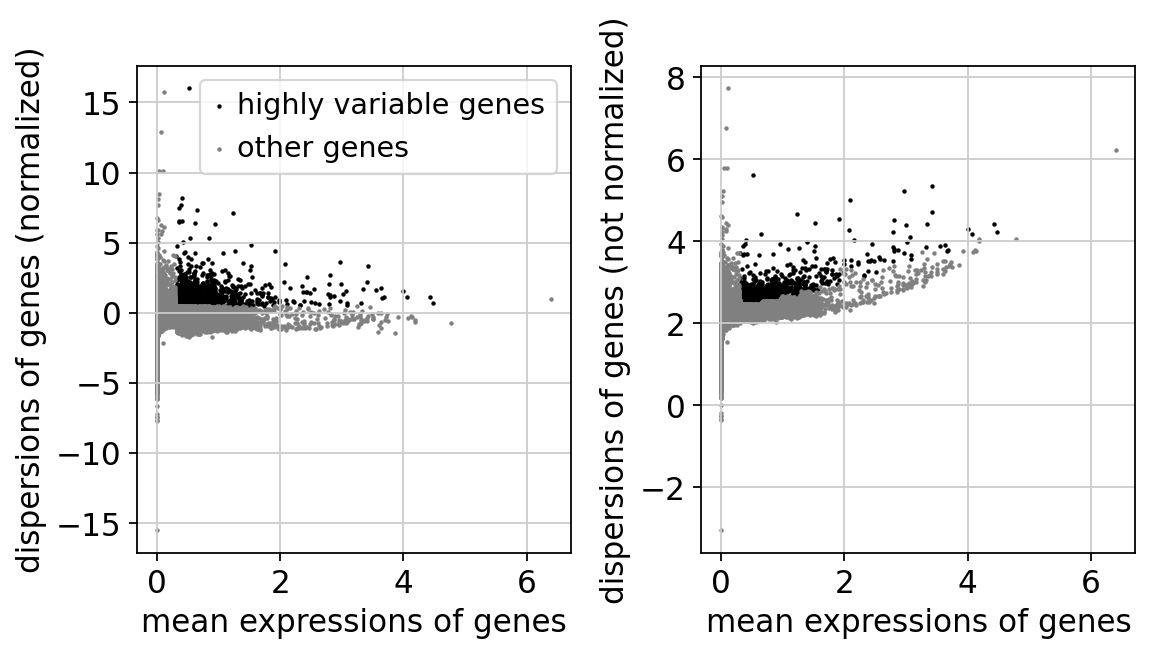

In [8]:
sc.pl.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)


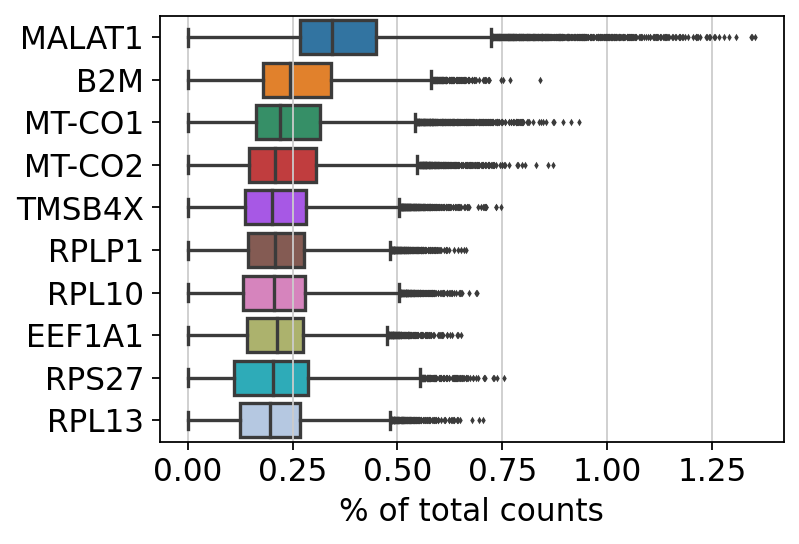

In [9]:
sc.pl.highest_expr_genes(adata, n_top=10, show=True)

In [10]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


In [11]:
sc.tl.umap(adata)

computing UMAP


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.58it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


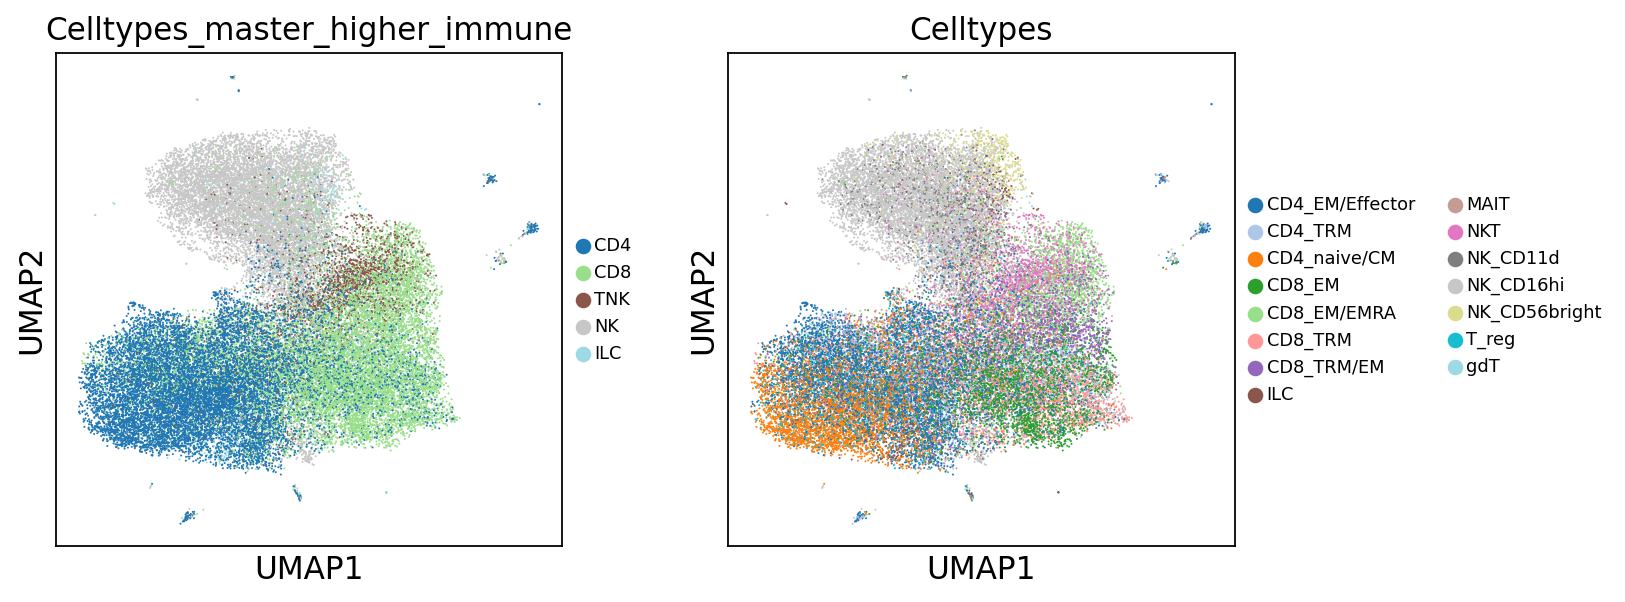

In [12]:
sc.pl.umap(adata, color=["Celltypes_master_higher_immune", "Celltypes"],#save= "Lymphoid.png",
           palette="tab20",legend_fontoutline=1, legend_fontsize=8)

<AxesSubplot:title={'center':'cell count'}>

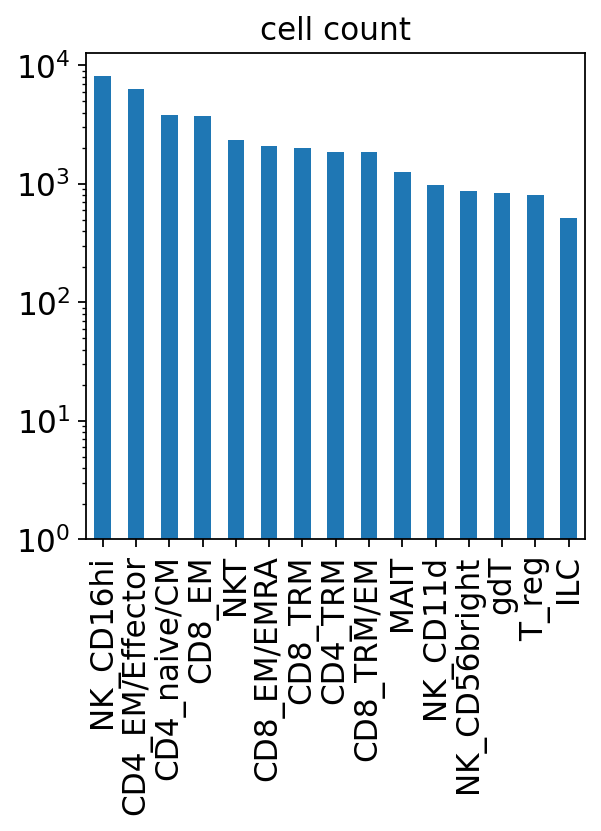

In [13]:
adata.obs['Celltypes'].value_counts().plot(kind='bar', log="y",
                                           grid=False, title='cell count')

ranking genes
    consider 'Celltypes' groups:
    with sizes: [6367 1859 3804 3781 2085 2023 1854  517 1254 2335  982 8116  876  808
  841]
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:34)


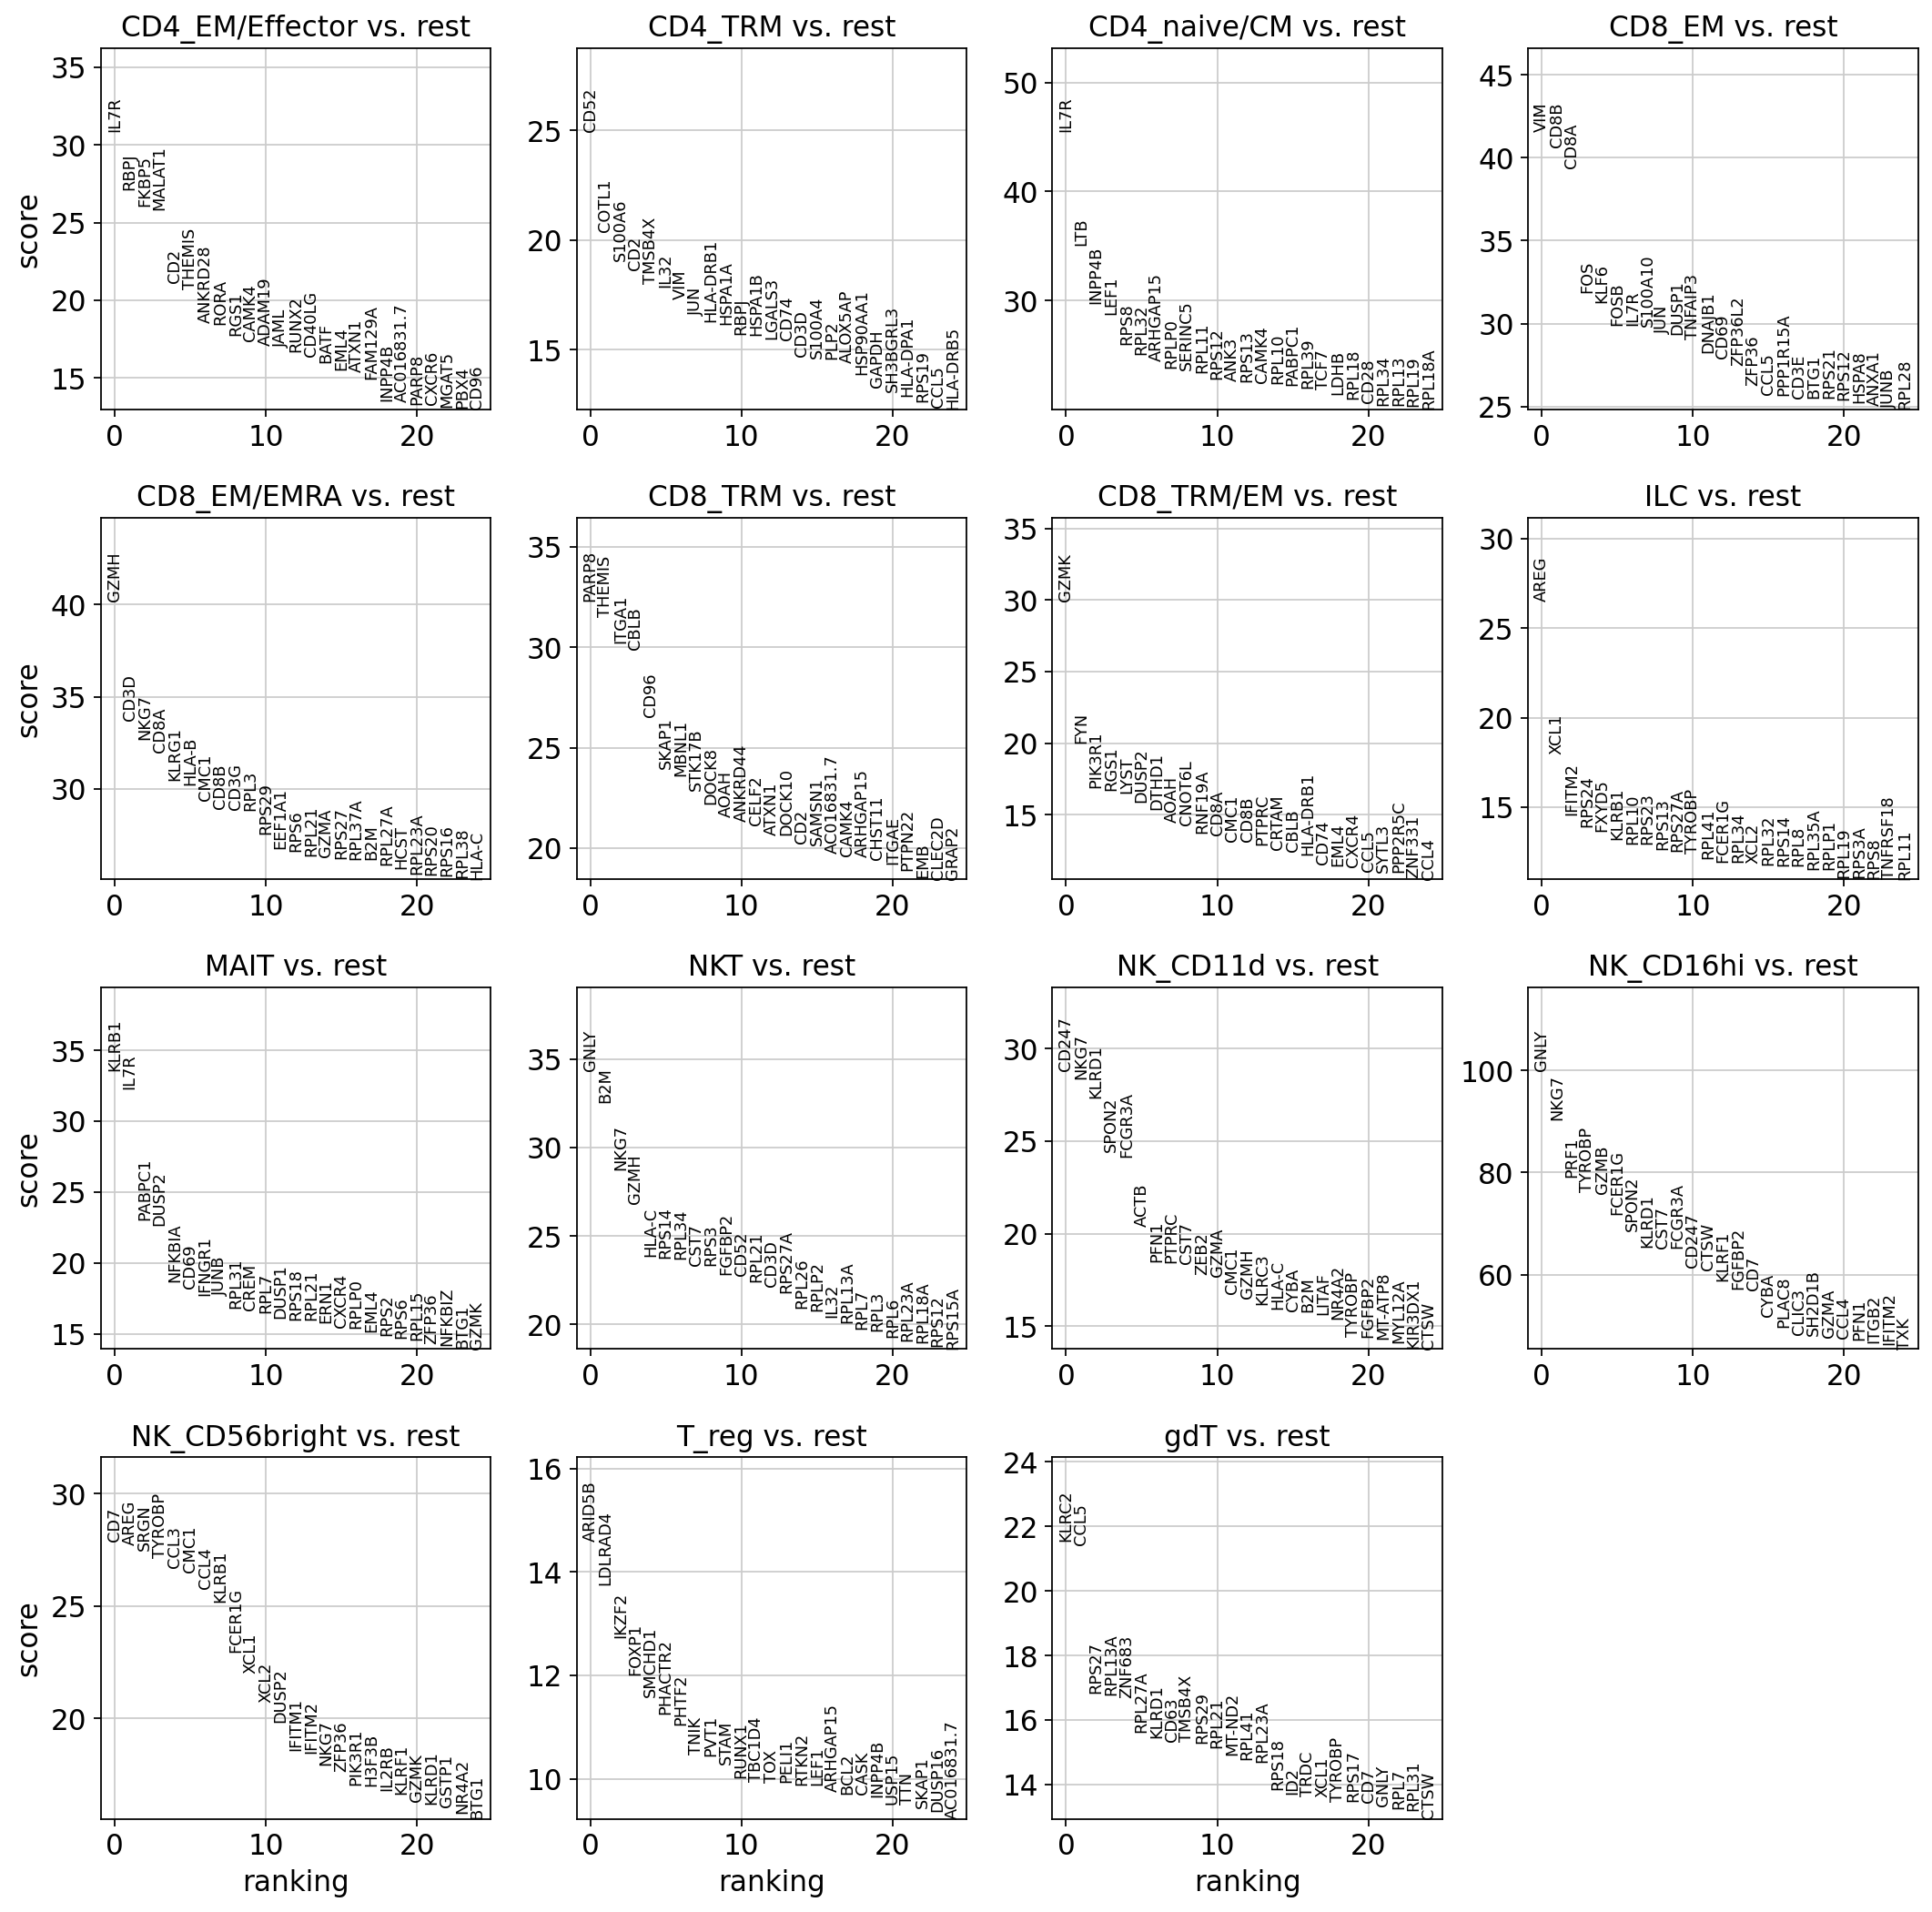

In [14]:
sc.tl.rank_genes_groups(adata, groupby= 'Celltypes', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(adata,  n_genes=25,  sharey=False, key= "wilcoxon")

In [15]:
adata.X.max()

8.704013

In [16]:
adata.write(tmpfile)

## Read prepocessed data

In [5]:
adata = sc.read_h5ad(tmpfile)

In [8]:
adata.obs.Celltypes.cat.categories

Index(['CD4_EM/Effector', 'CD4_TRM', 'CD4_naive/CM', 'CD8_EM', 'CD8_EM/EMRA',
       'CD8_TRM', 'CD8_TRM/EM', 'ILC', 'MAIT', 'NKT', 'NK_CD11d', 'NK_CD16hi',
       'NK_CD56bright', 'T_reg', 'gdT'],
      dtype='object')

In [9]:
for clust in adata.obs.Celltypes.cat.categories: 
    c = clust
    c = c.replace("/", "_")
    f = "./DE_genelists_log2FC/Tcells/" + c + ".csv"
    df = sc.get.rank_genes_groups_df(adata, group=clust,
                                    key='wilcoxon')
    df.to_csv(f, sep=",")

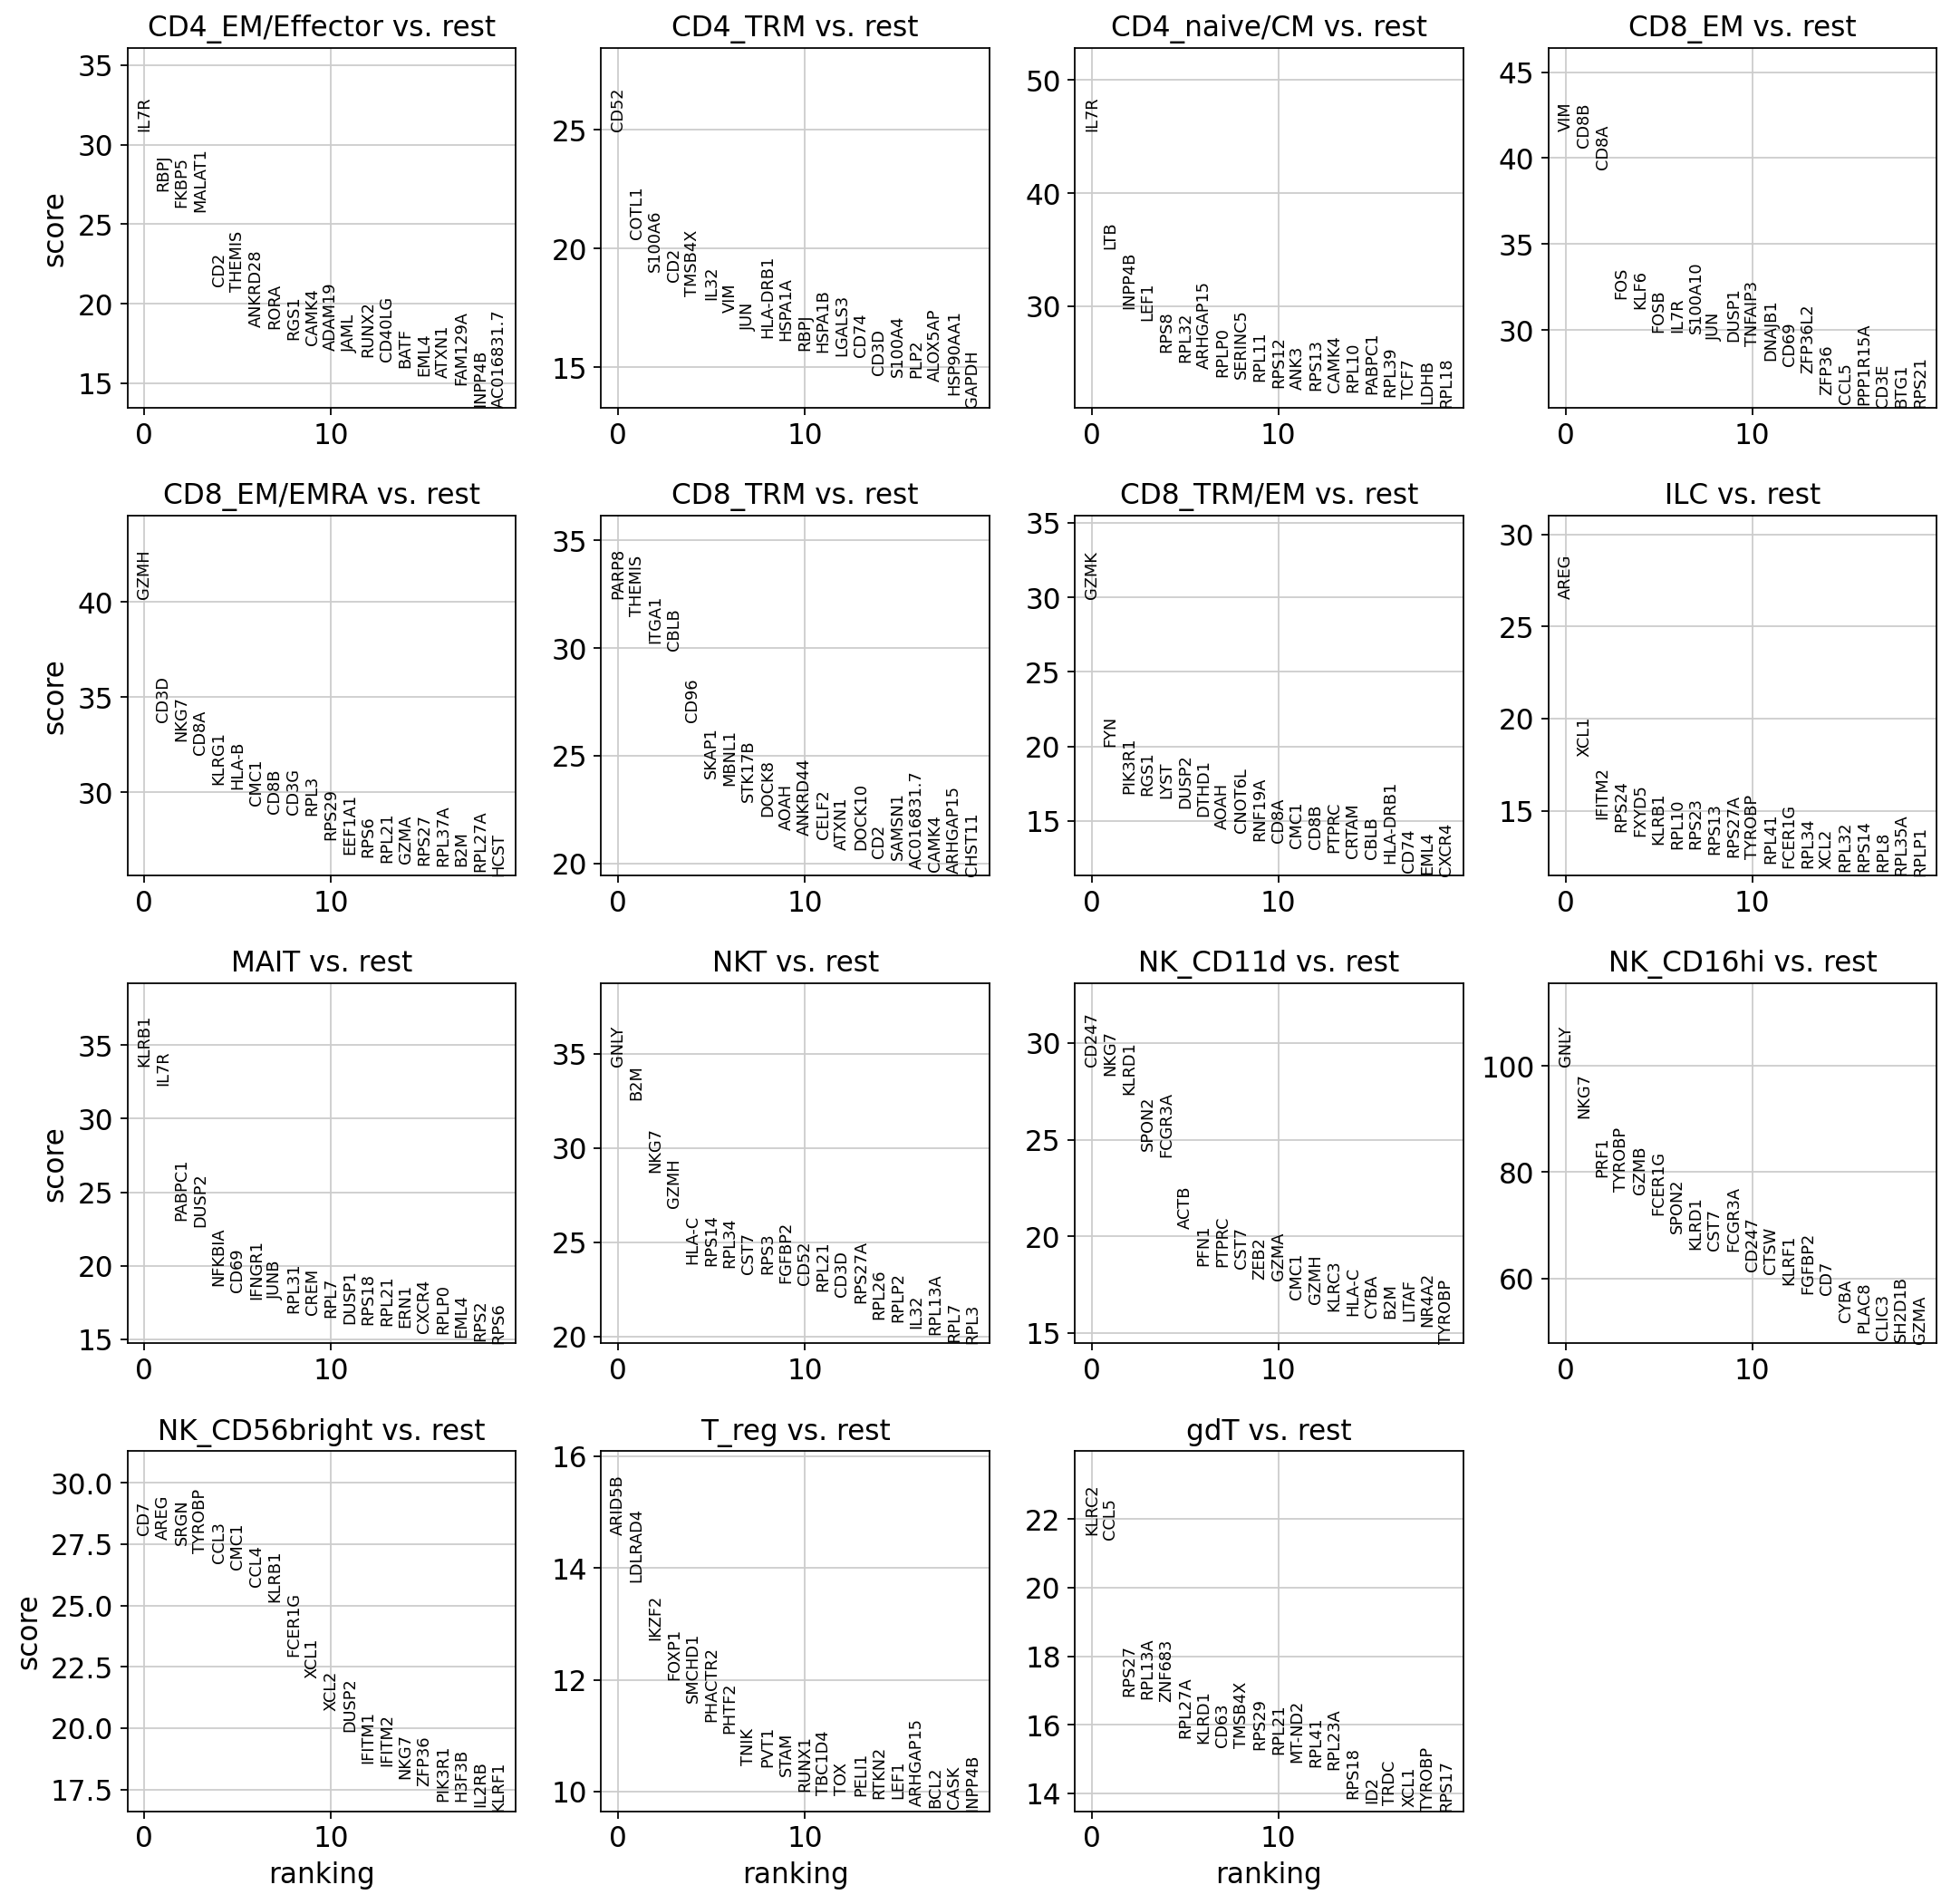

In [18]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key = "wilcoxon")

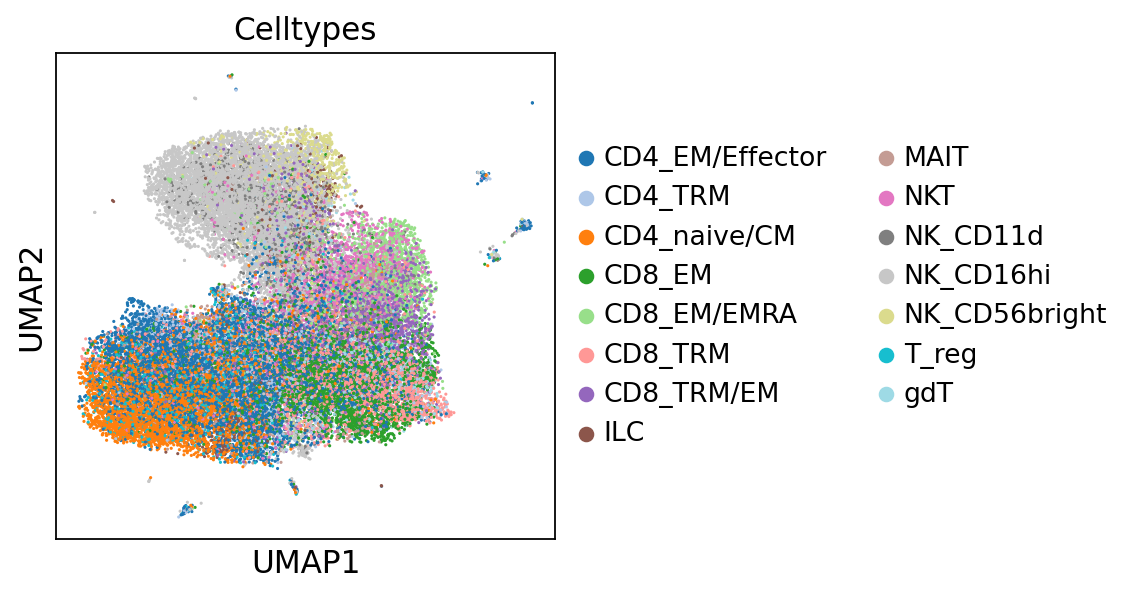

In [19]:
sc.pl.umap(adata, color="Celltypes",#save= "Lymphoid.png",
           legend_fontoutline=1, size=8, legend_fontsize=12)

## Loop to produce the lists of Tcell lineages

In [20]:
Subtypes = adata.obs['Celltypes'].unique()
Subtypes

['CD8_EM/EMRA', 'CD8_EM', 'ILC', 'NK_CD11d', 'MAIT', ..., 'CD4_naive/CM', 'NKT', 'gdT', 'CD8_TRM', 'NK_CD56bright']
Length: 15
Categories (15, object): ['CD4_EM/Effector', 'CD4_TRM', 'CD4_naive/CM', 'CD8_EM', ..., 'NK_CD16hi', 'NK_CD56bright', 'T_reg', 'gdT']

In [21]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 CD8_EM/EMRA
1 CD8_EM
2 ILC
3 NK_CD11d
4 MAIT
5 T_reg
6 CD4_EM/Effector
7 NK_CD16hi
8 CD8_TRM/EM
9 CD4_TRM
10 CD4_naive/CM
11 NKT
12 gdT
13 CD8_TRM
14 NK_CD56bright


### Marker genes for each Subtype

In [22]:
Markers = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    m = sc.get.rank_genes_groups_df(adata, group=Subtypes[i],
                                    key='wilcoxon', pval_cutoff=0.0001,
                                    log2fc_min=1)
    m = m.sort_values("logfoldchanges", ascending=False)
    m.reset_index(drop=True, inplace=True)
    Markers[i] = m

0 CD8_EM/EMRA
1 CD8_EM
2 ILC
3 NK_CD11d
4 MAIT
5 T_reg
6 CD4_EM/Effector
7 NK_CD16hi
8 CD8_TRM/EM
9 CD4_TRM
10 CD4_naive/CM
11 NKT
12 gdT
13 CD8_TRM
14 NK_CD56bright


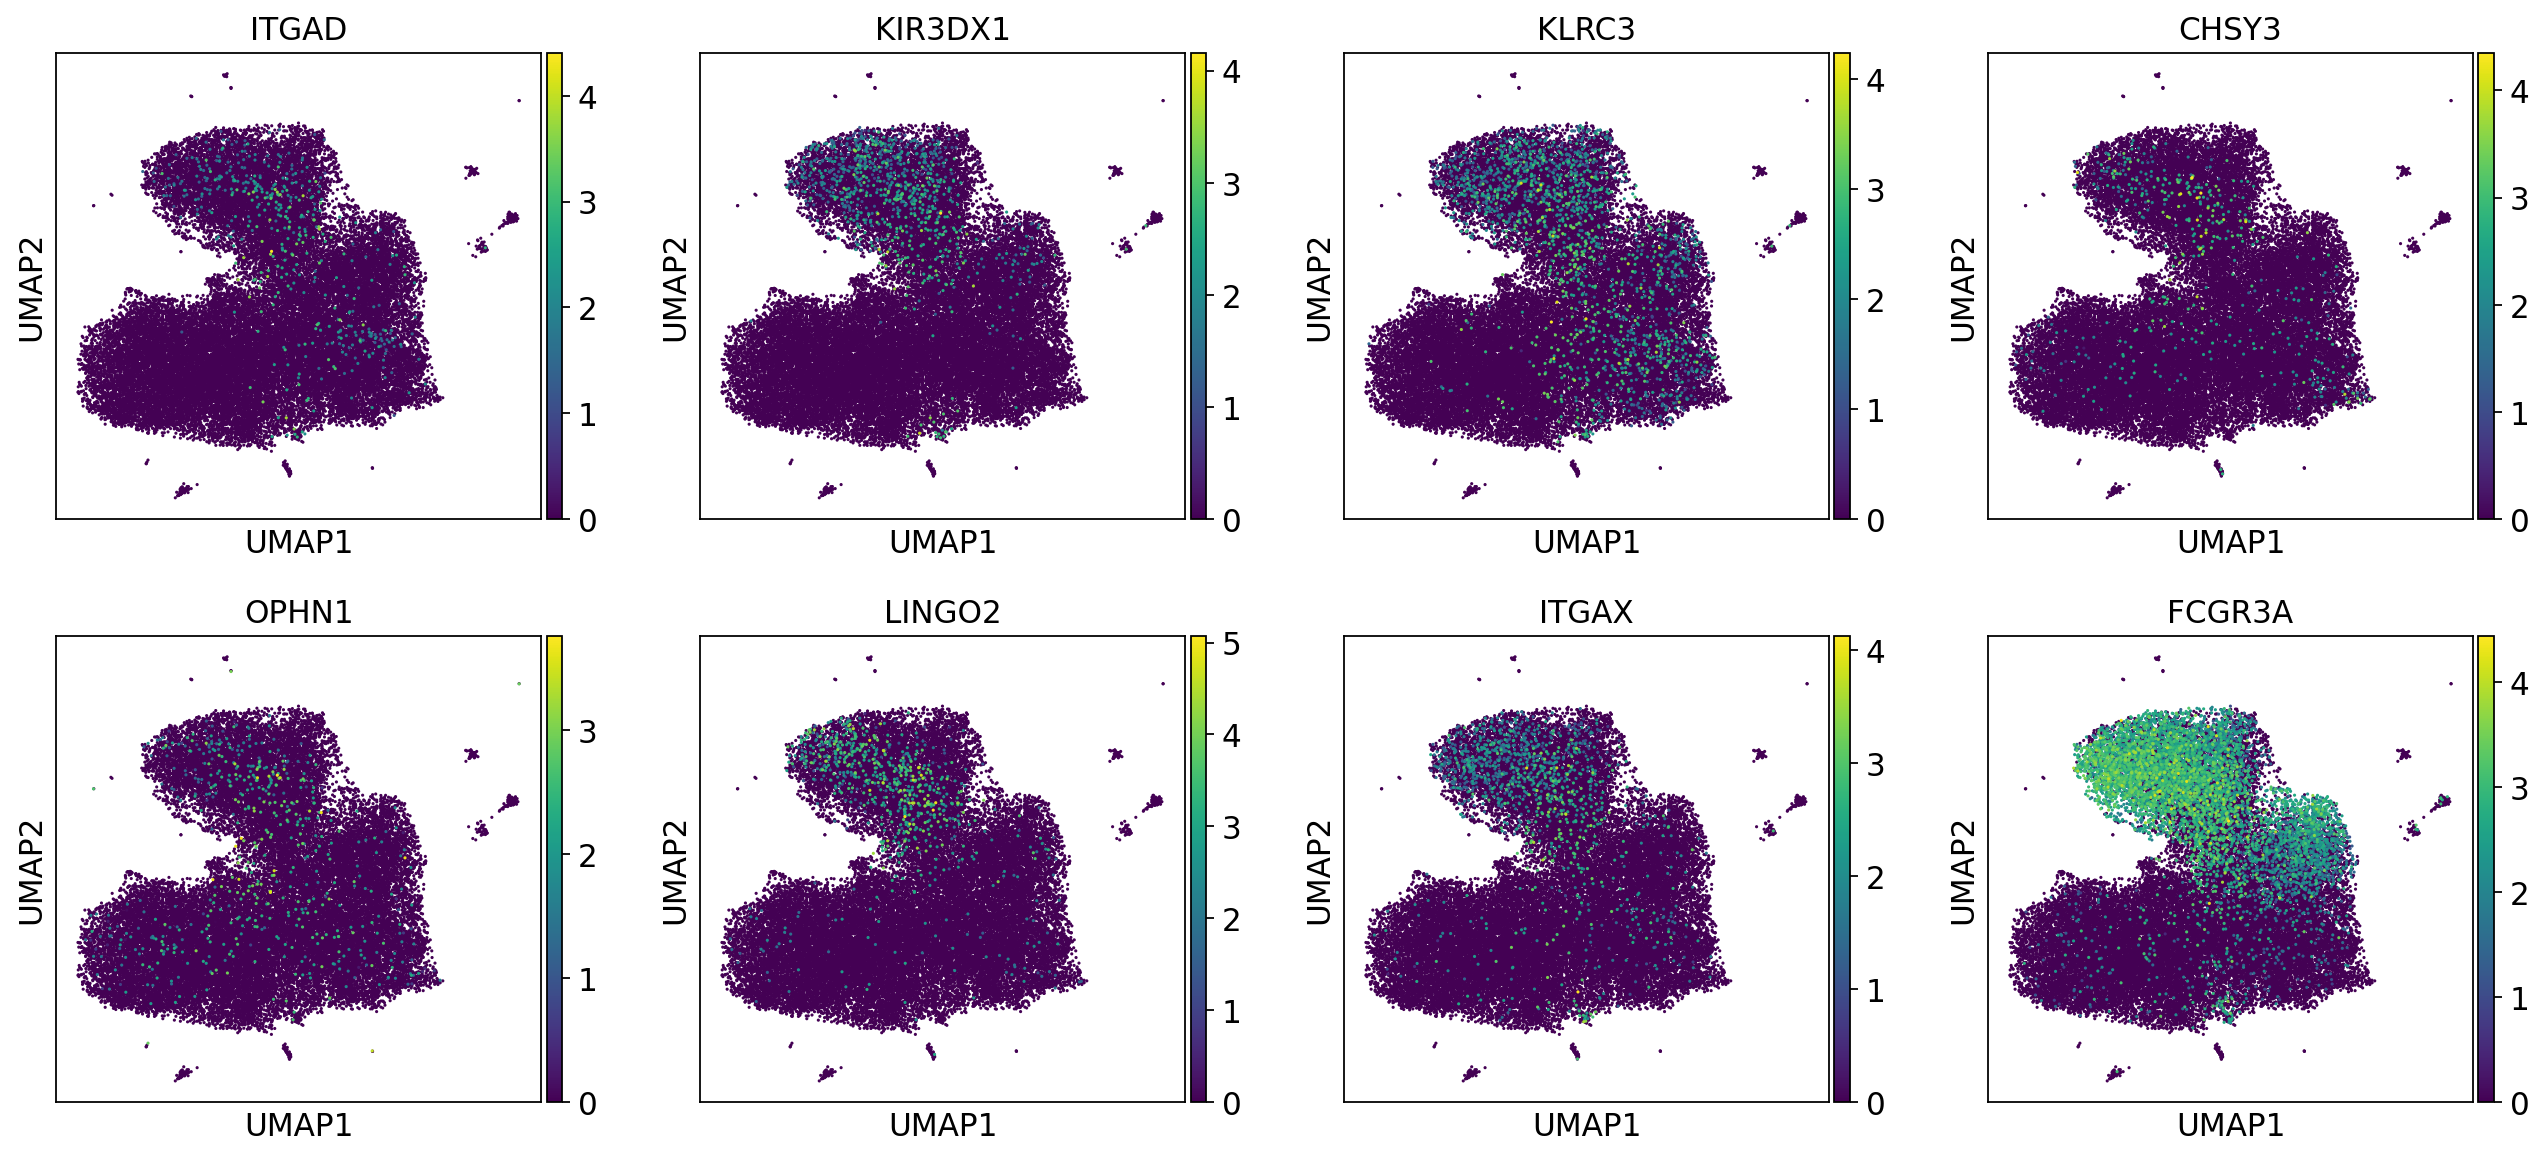

In [23]:
sc.pl.umap(adata, color= Markers[3]["names"][0:8], size=8 ) # top

0 CD8_EM/EMRA


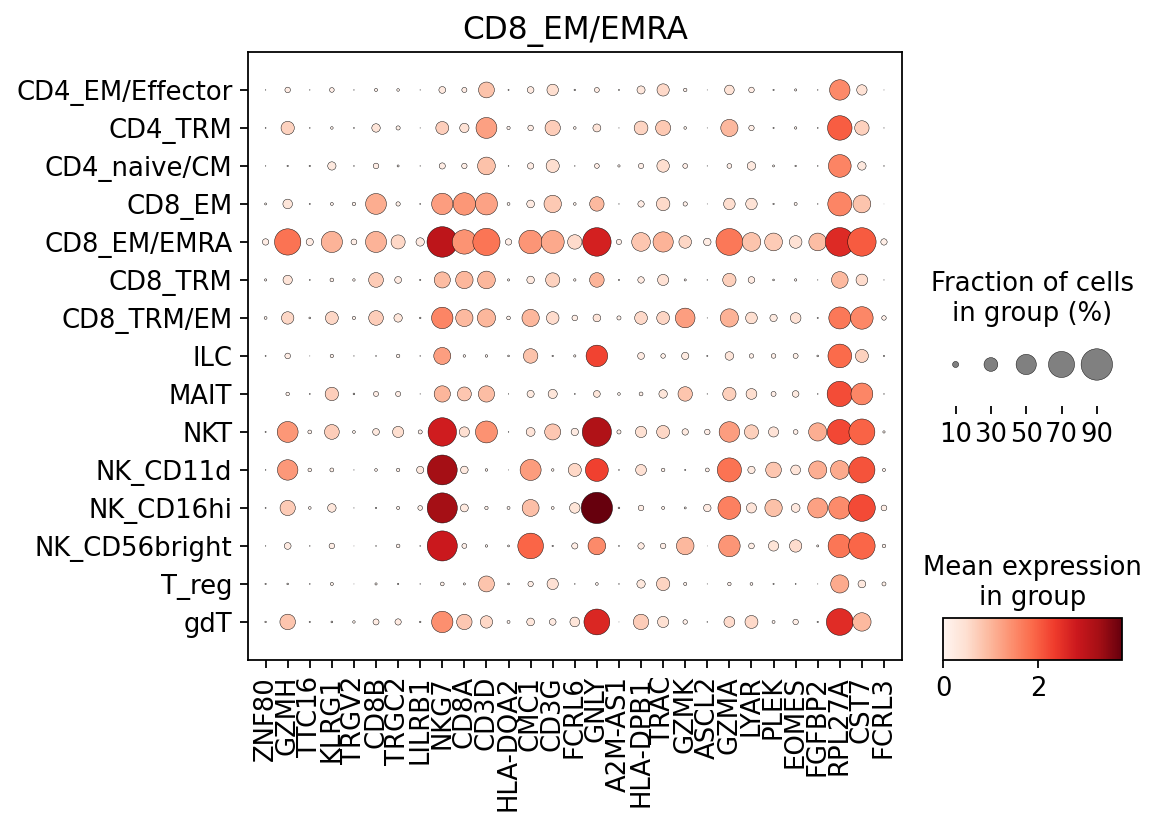

1 CD8_EM


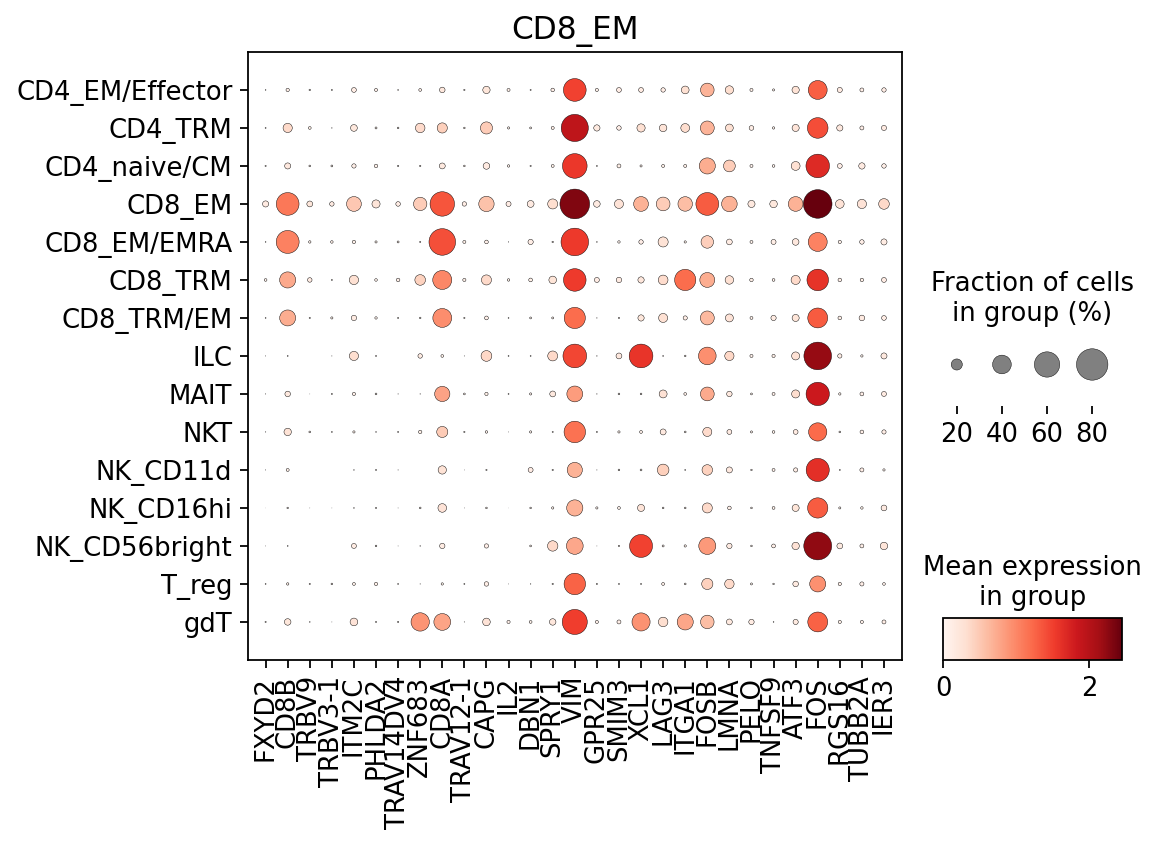

2 ILC


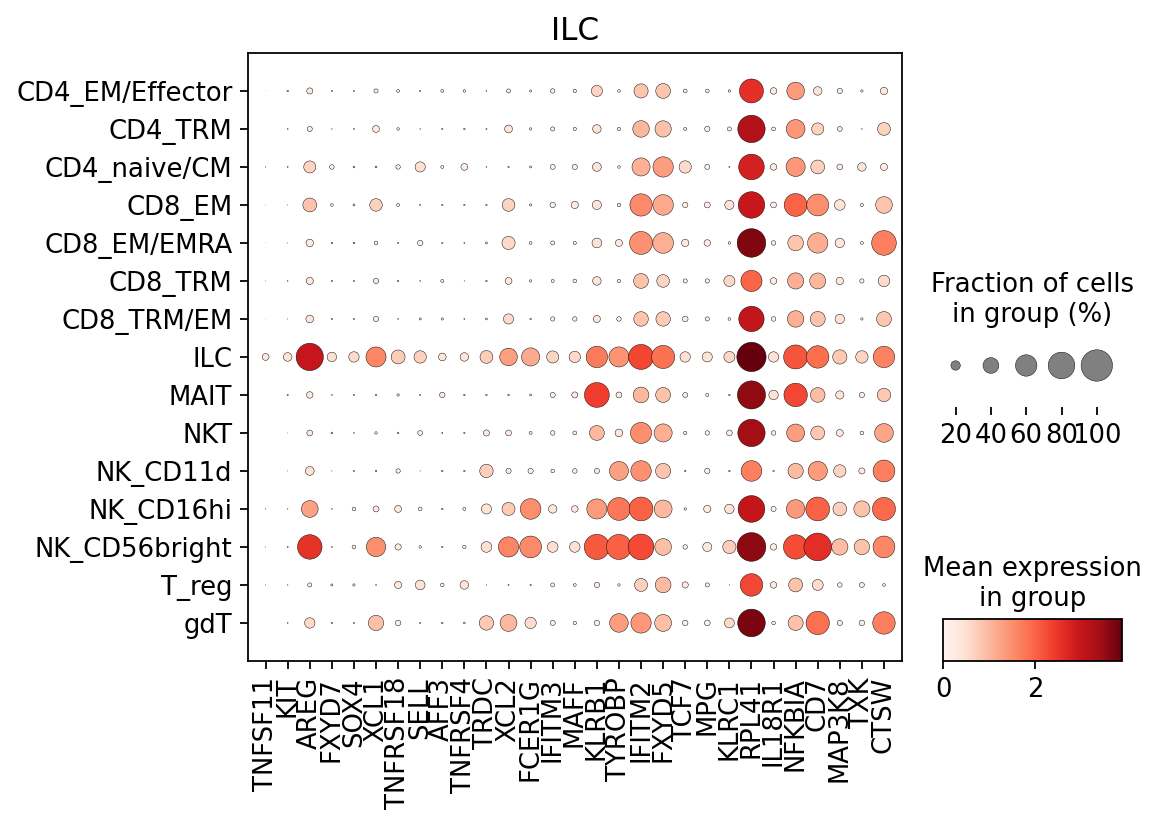

3 NK_CD11d


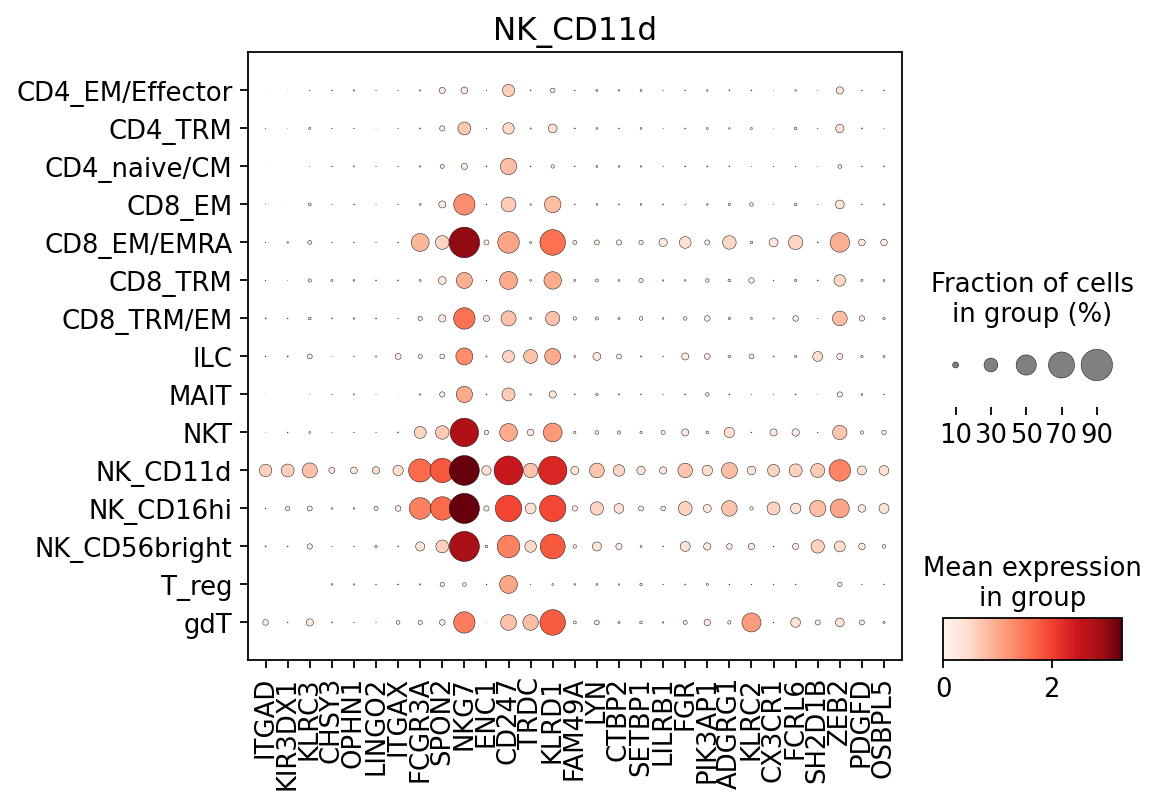

4 MAIT


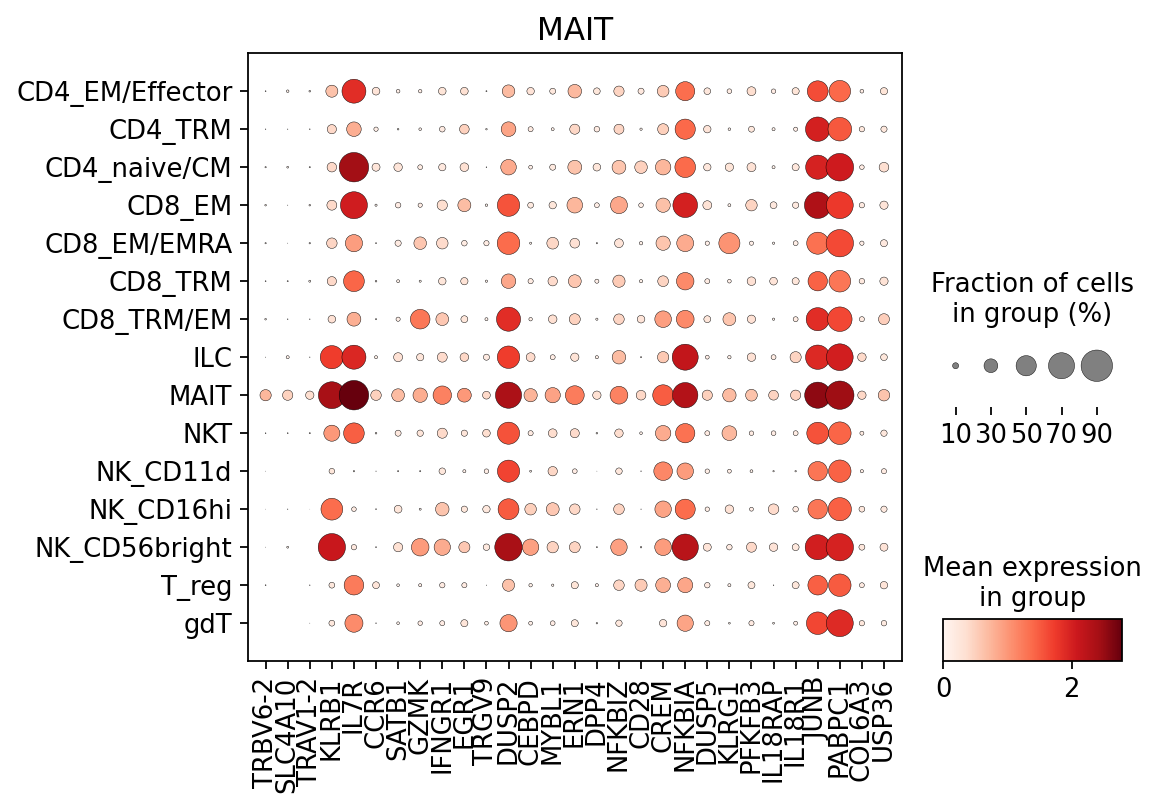

5 T_reg


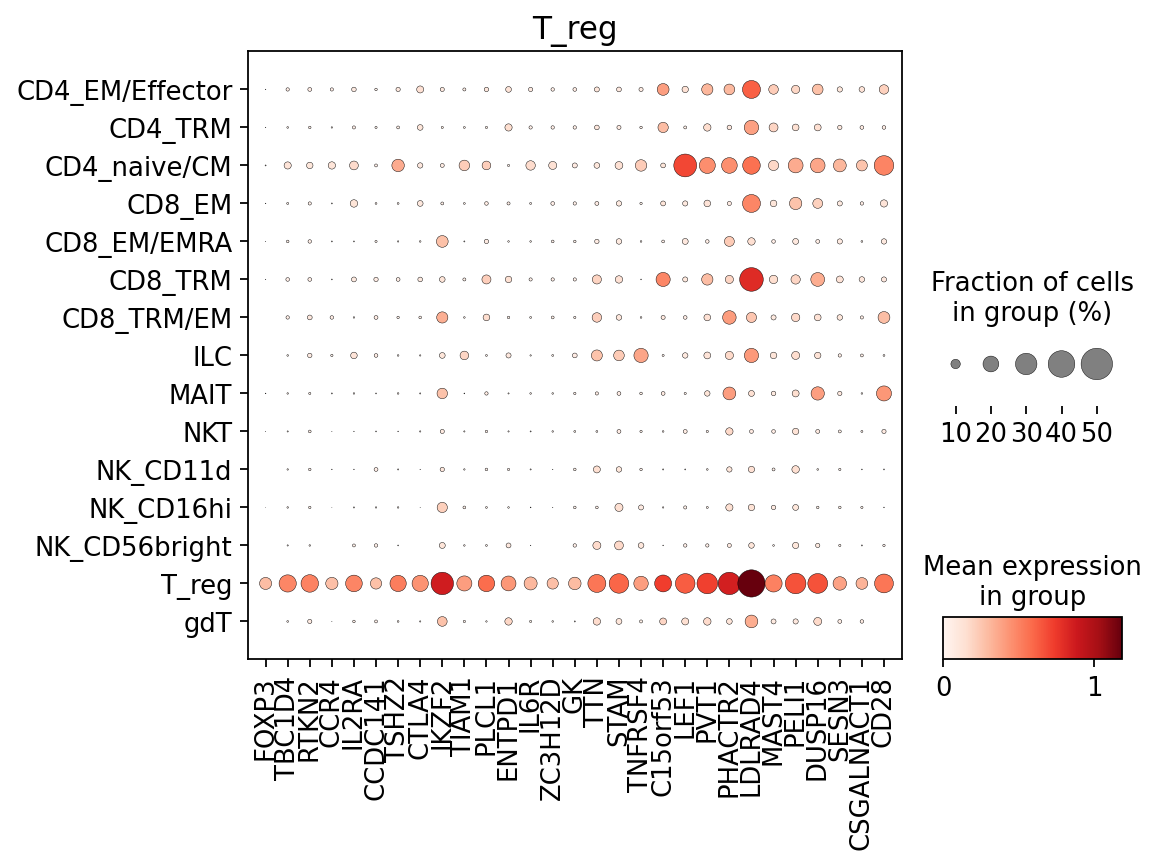

6 CD4_EM/Effector


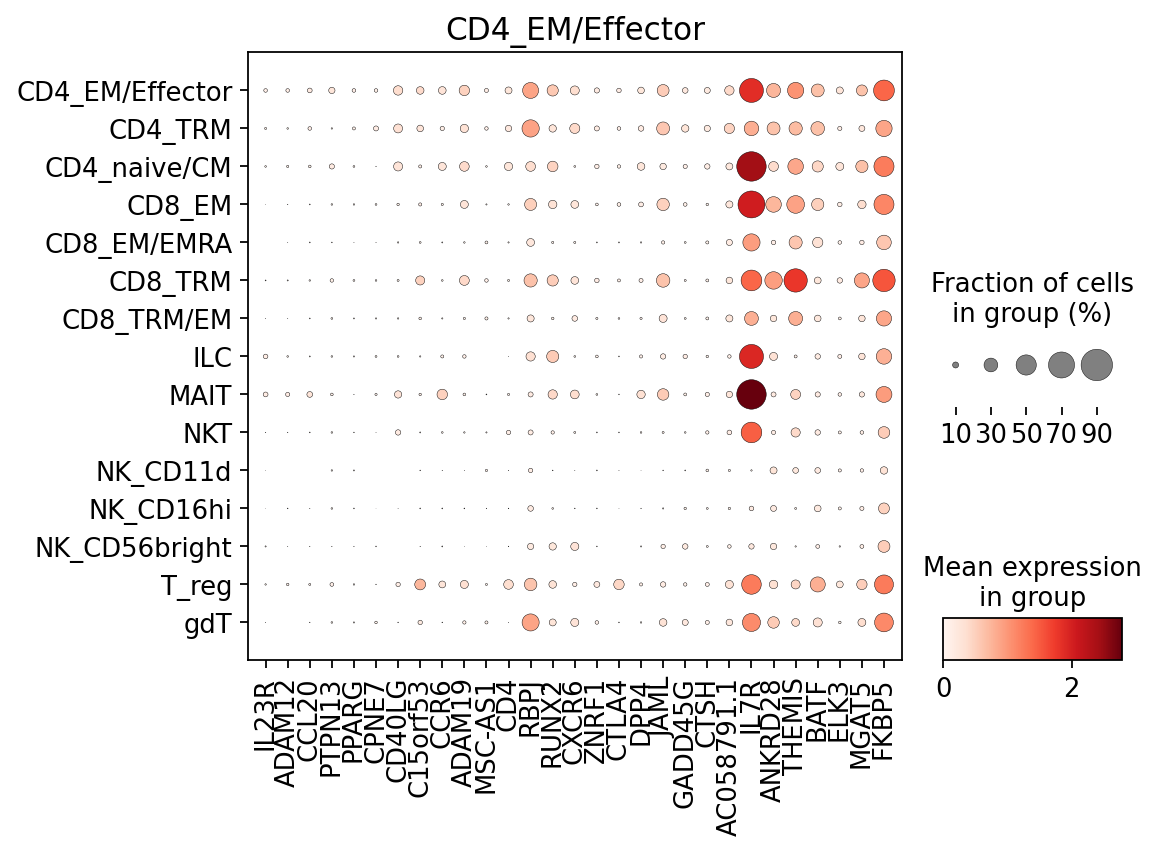

7 NK_CD16hi


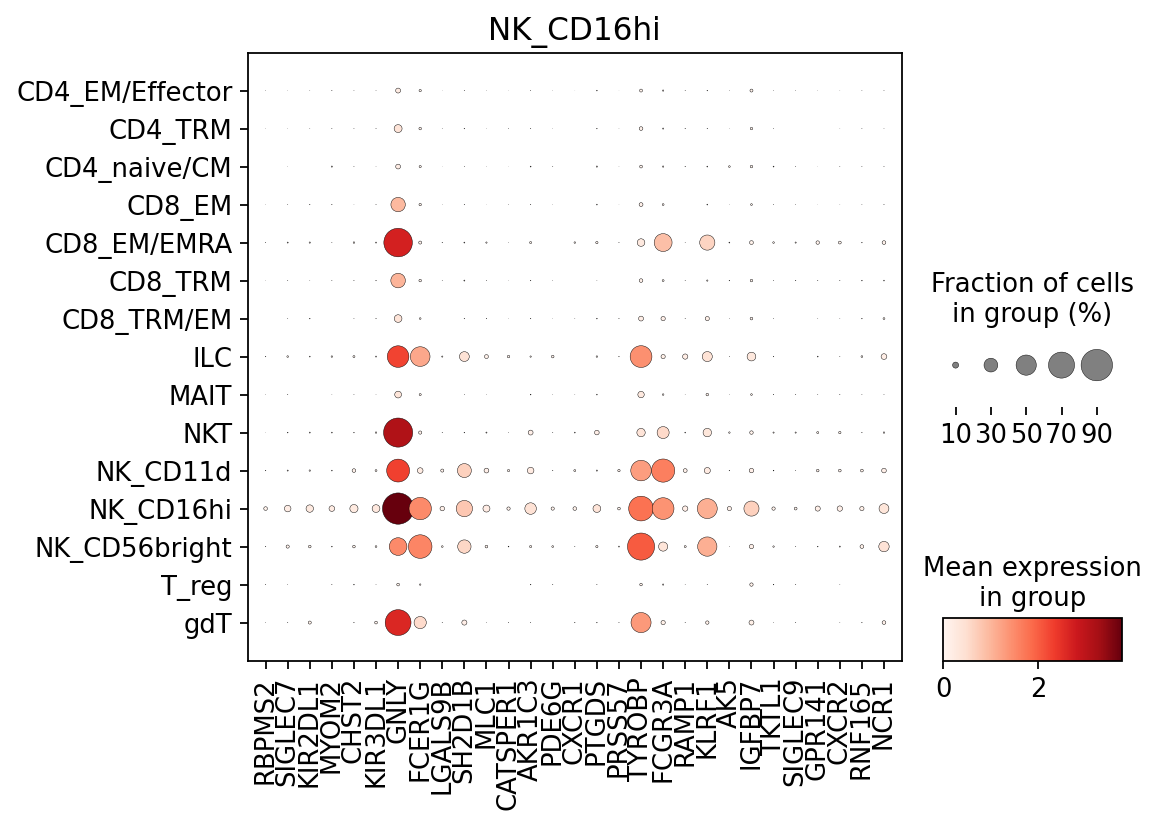

8 CD8_TRM/EM


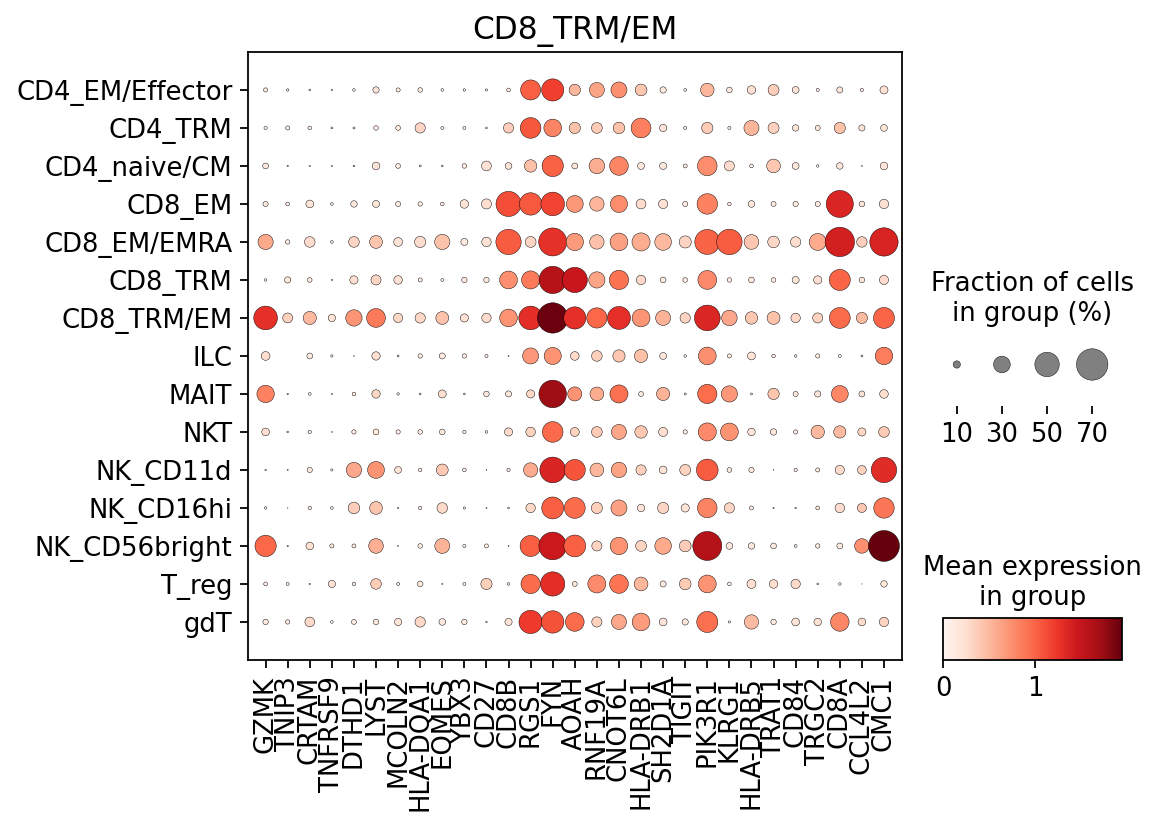

9 CD4_TRM


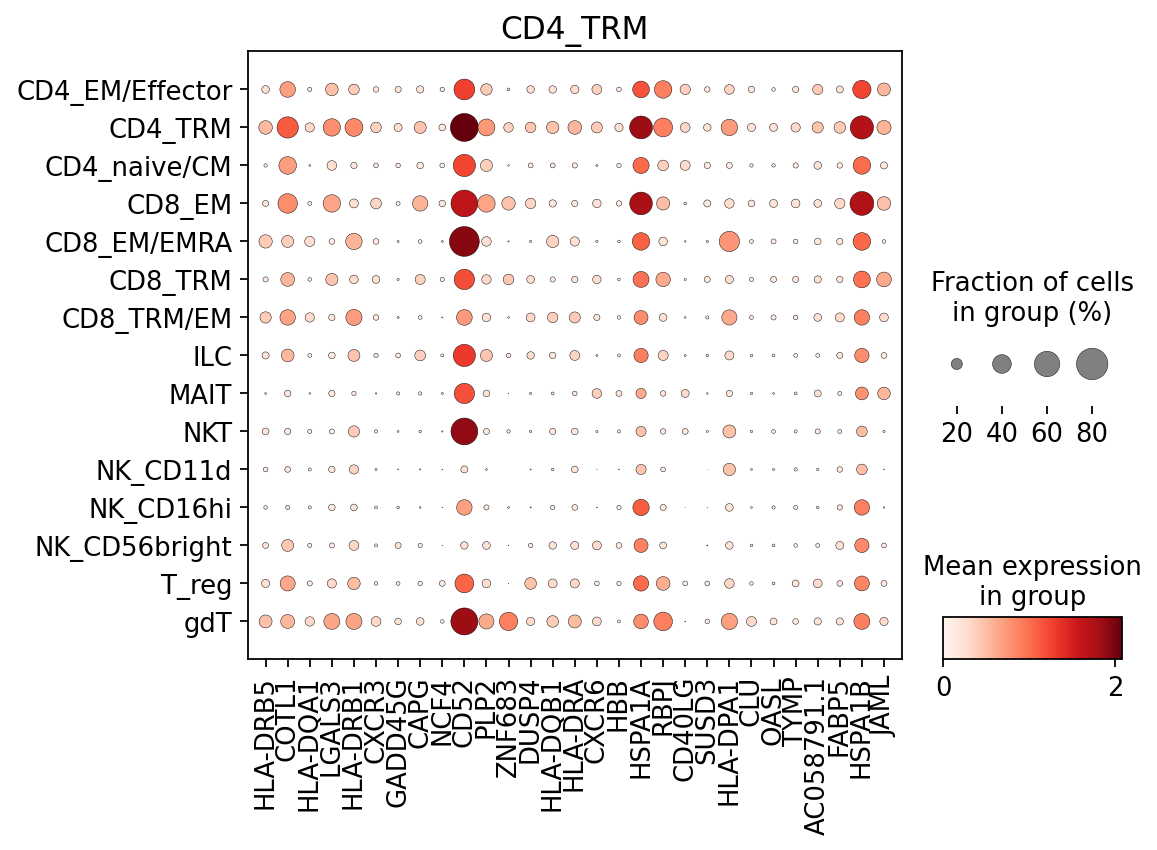

10 CD4_naive/CM


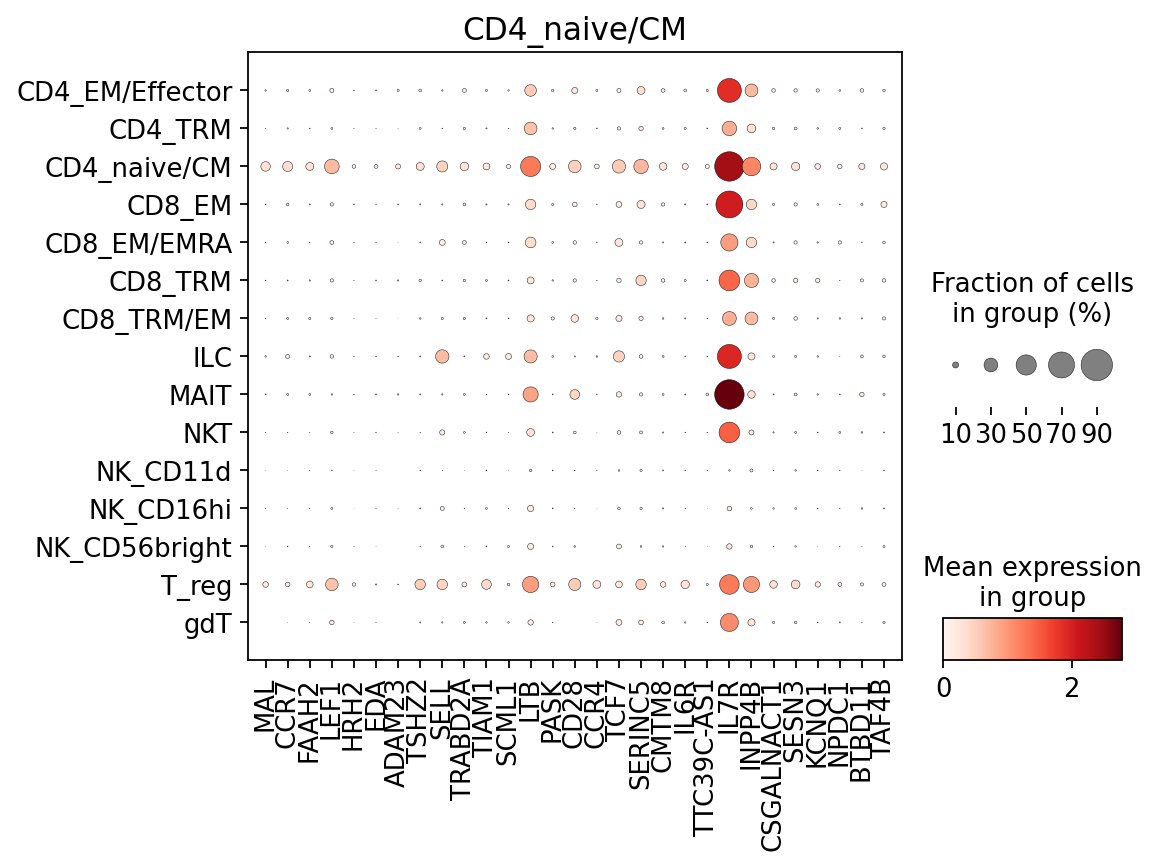

11 NKT


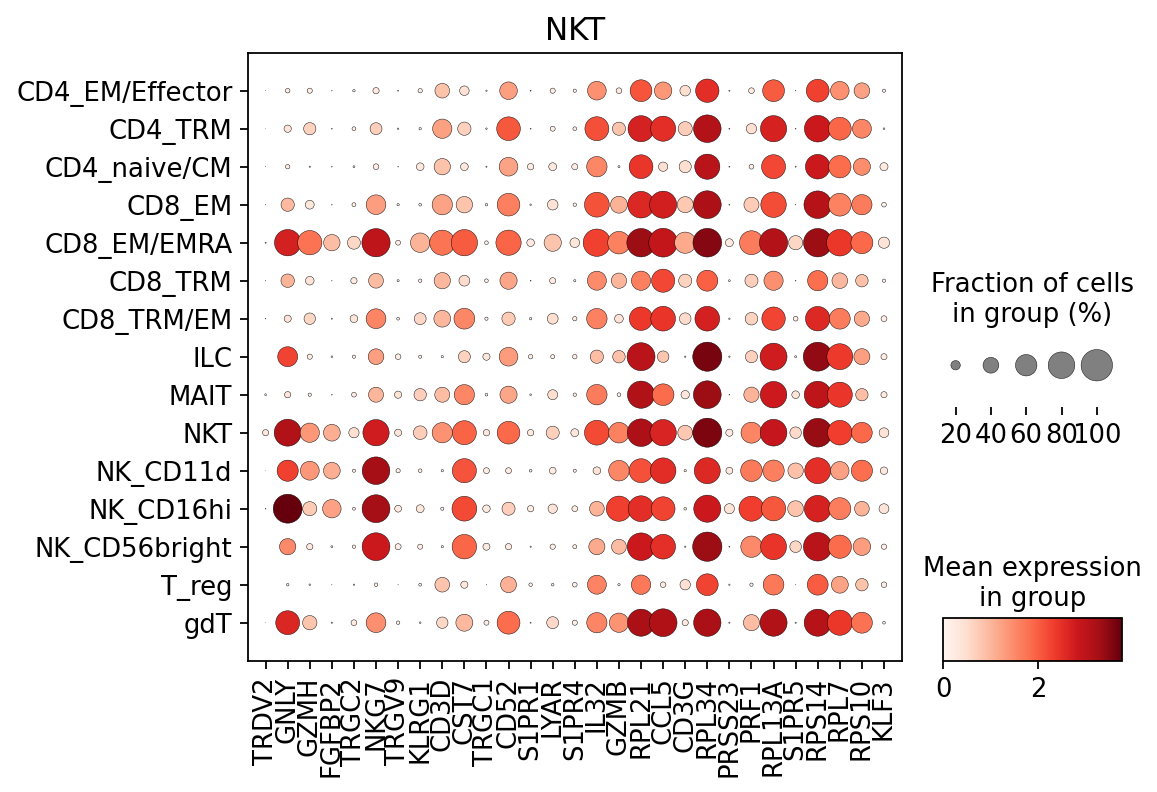

12 gdT


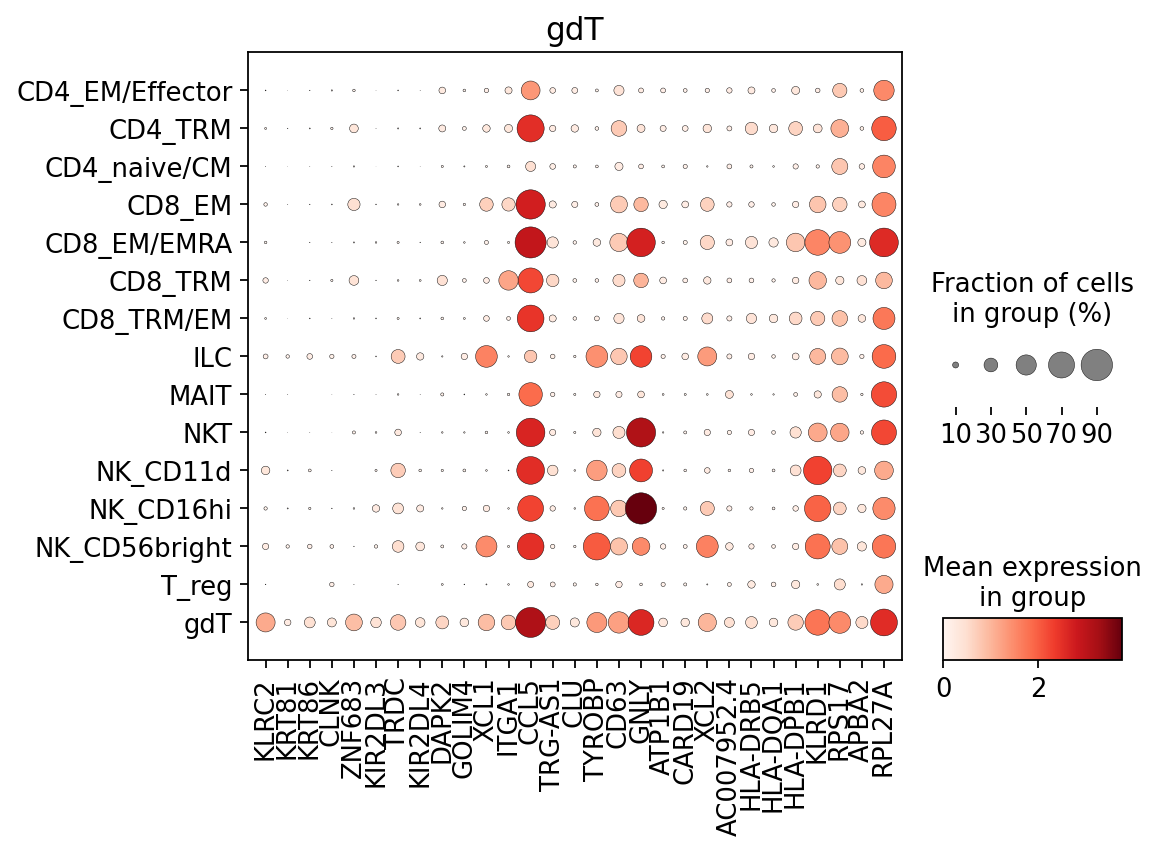

13 CD8_TRM


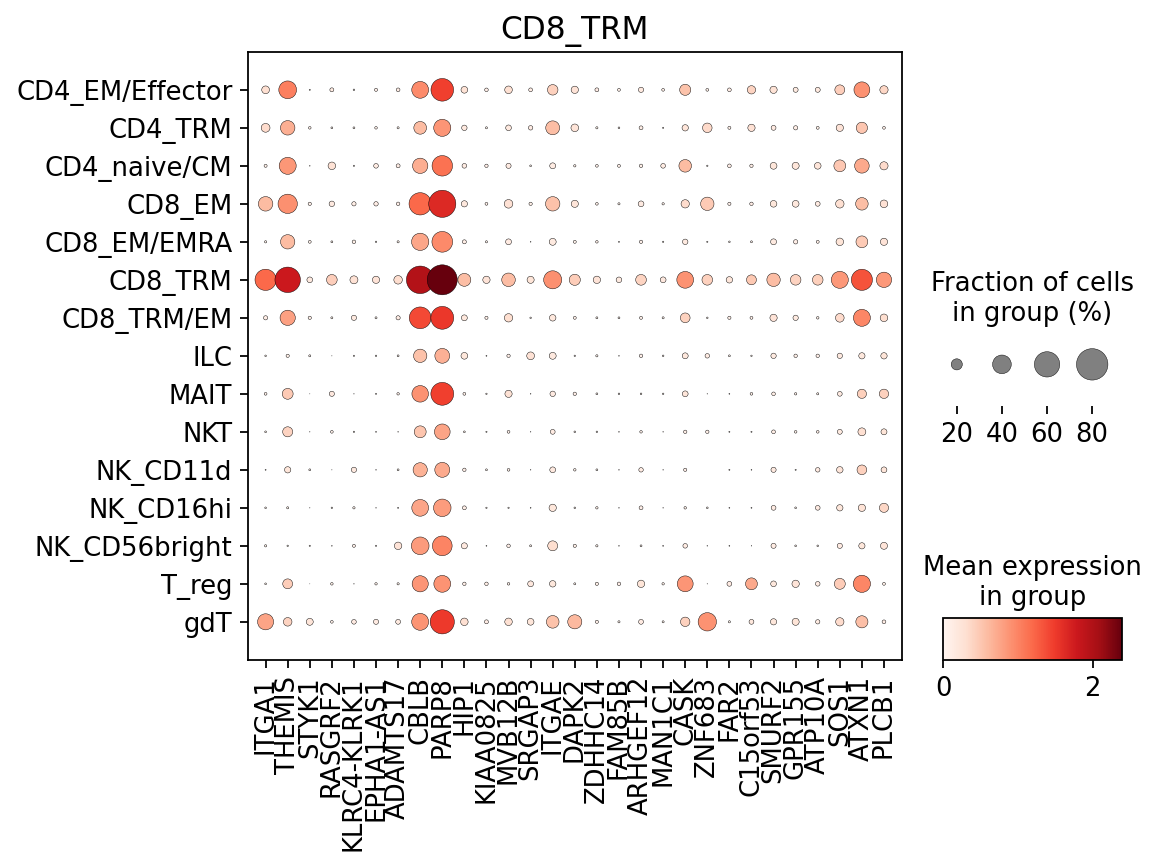

14 NK_CD56bright


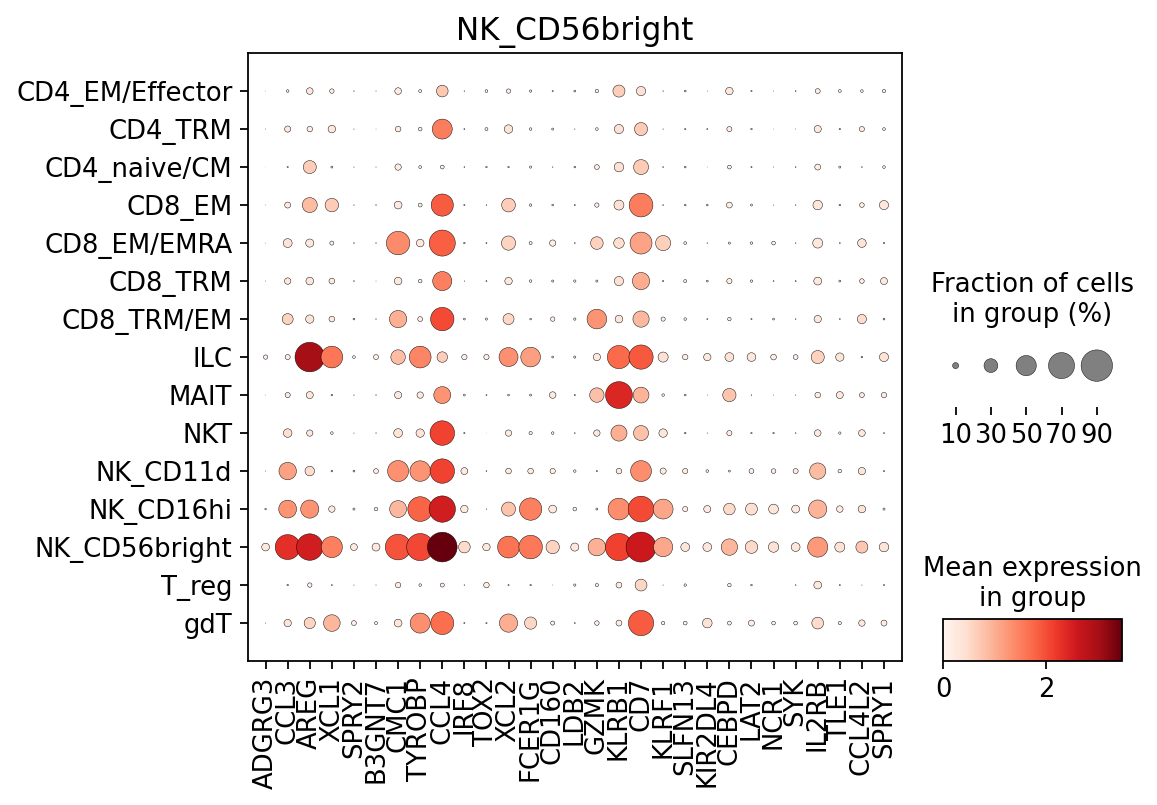

In [24]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    sc.pl.dotplot(adata, Markers[i]["names"][0:29], groupby='Celltypes', title= Subtypes[i], figsize= (7,5))

### Get names of 500 top markers (if possible) for each Subtype

In [25]:
#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [26]:
Sets = [[]]*len(Subtypes)
CompleteSets = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    CompleteSets[i] = Markers[i]['names']
    n = len(Markers[i])
    print(i, Subtypes[i], n)
    if n > 500 :
        print("yes")
        Sets[i] = Markers[i].loc[0:499,'names']
    else :
        print("no")
        Sets[i] = Markers[i].loc[0:n-1,'names']

0 CD8_EM/EMRA 177
no
1 CD8_EM 149
no
2 ILC 56
no
3 NK_CD11d 130
no
4 MAIT 53
no
5 T_reg 166
no
6 CD4_EM/Effector 49
no
7 NK_CD16hi 409
no
8 CD8_TRM/EM 50
no
9 CD4_TRM 54
no
10 CD4_naive/CM 160
no
11 NKT 35
no
12 gdT 64
no
13 CD8_TRM 628
yes
14 NK_CD56bright 109
no


In [27]:
Dict_markers =  {}
CompleteDict_markers =  {}

for i in range(0,len(Subtypes)):
    Dict_markers[Subtypes[i]] = Sets[i]
    CompleteDict_markers[Subtypes[i]] = CompleteSets[i]

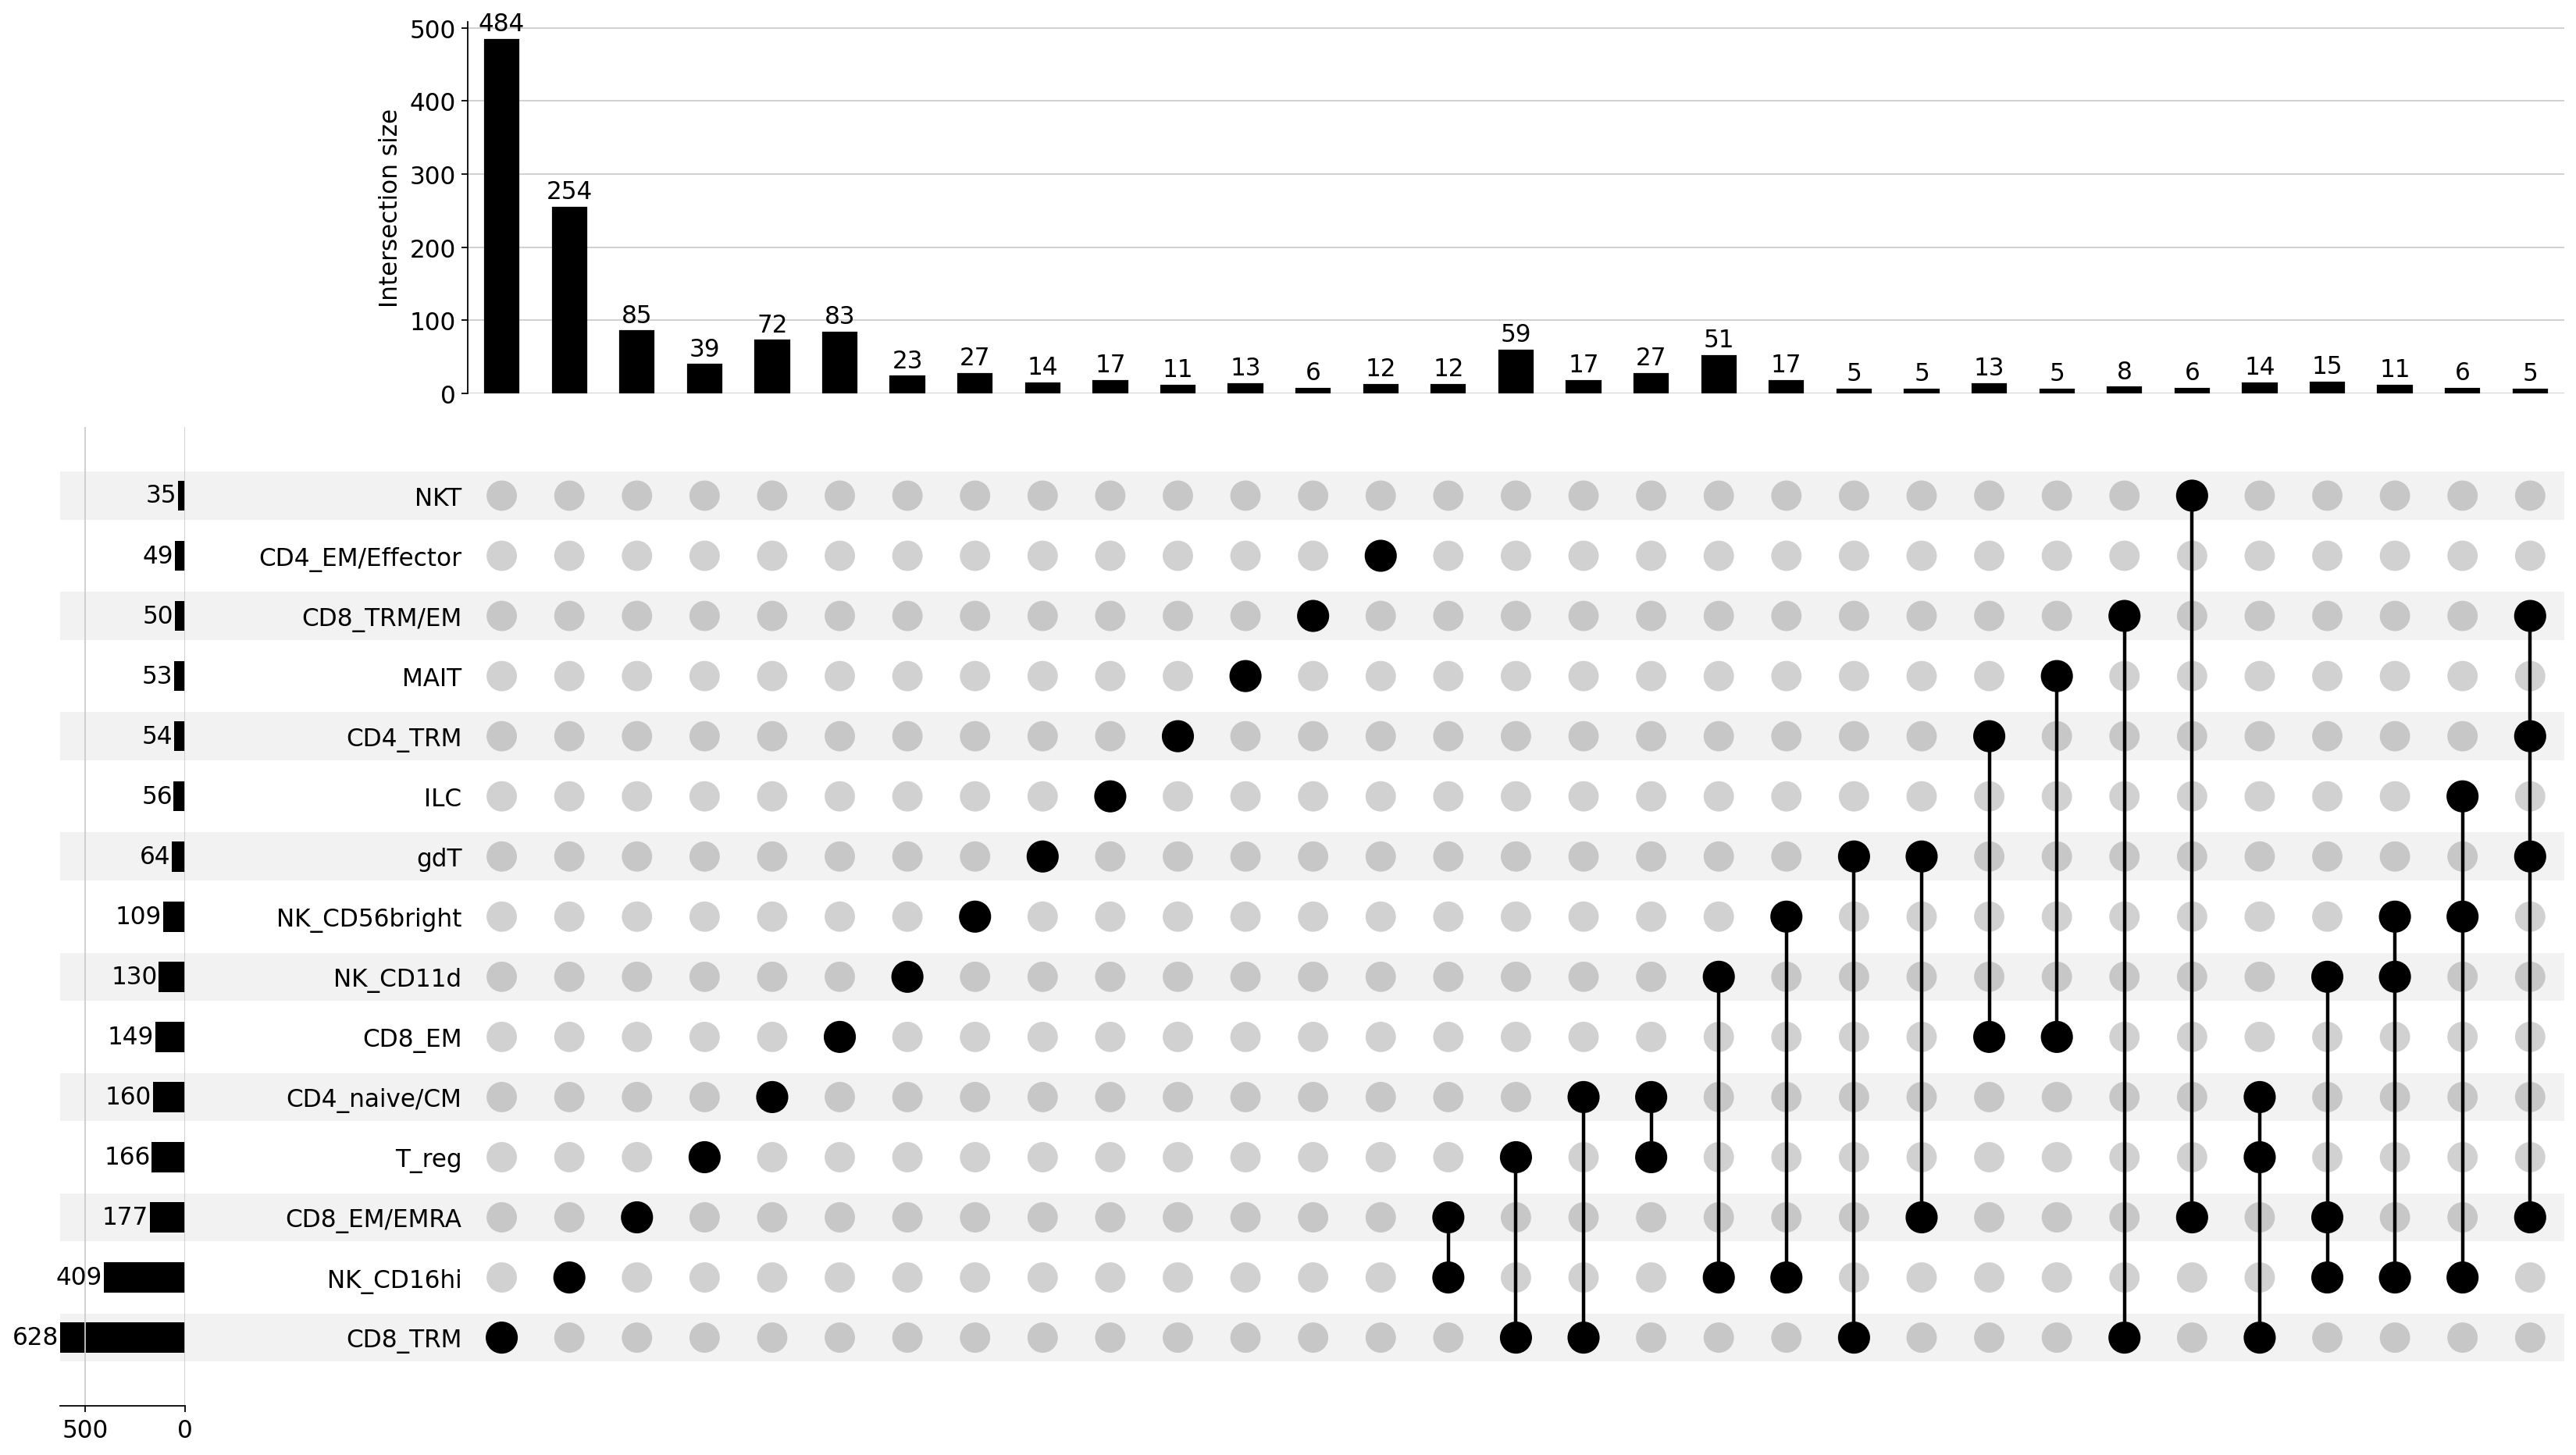

In [28]:
CT_markers = from_contents(CompleteDict_markers)

plt = UpSet(CT_markers, min_subset_size=5, subset_size='count',element_size=50,  show_counts=True).plot()

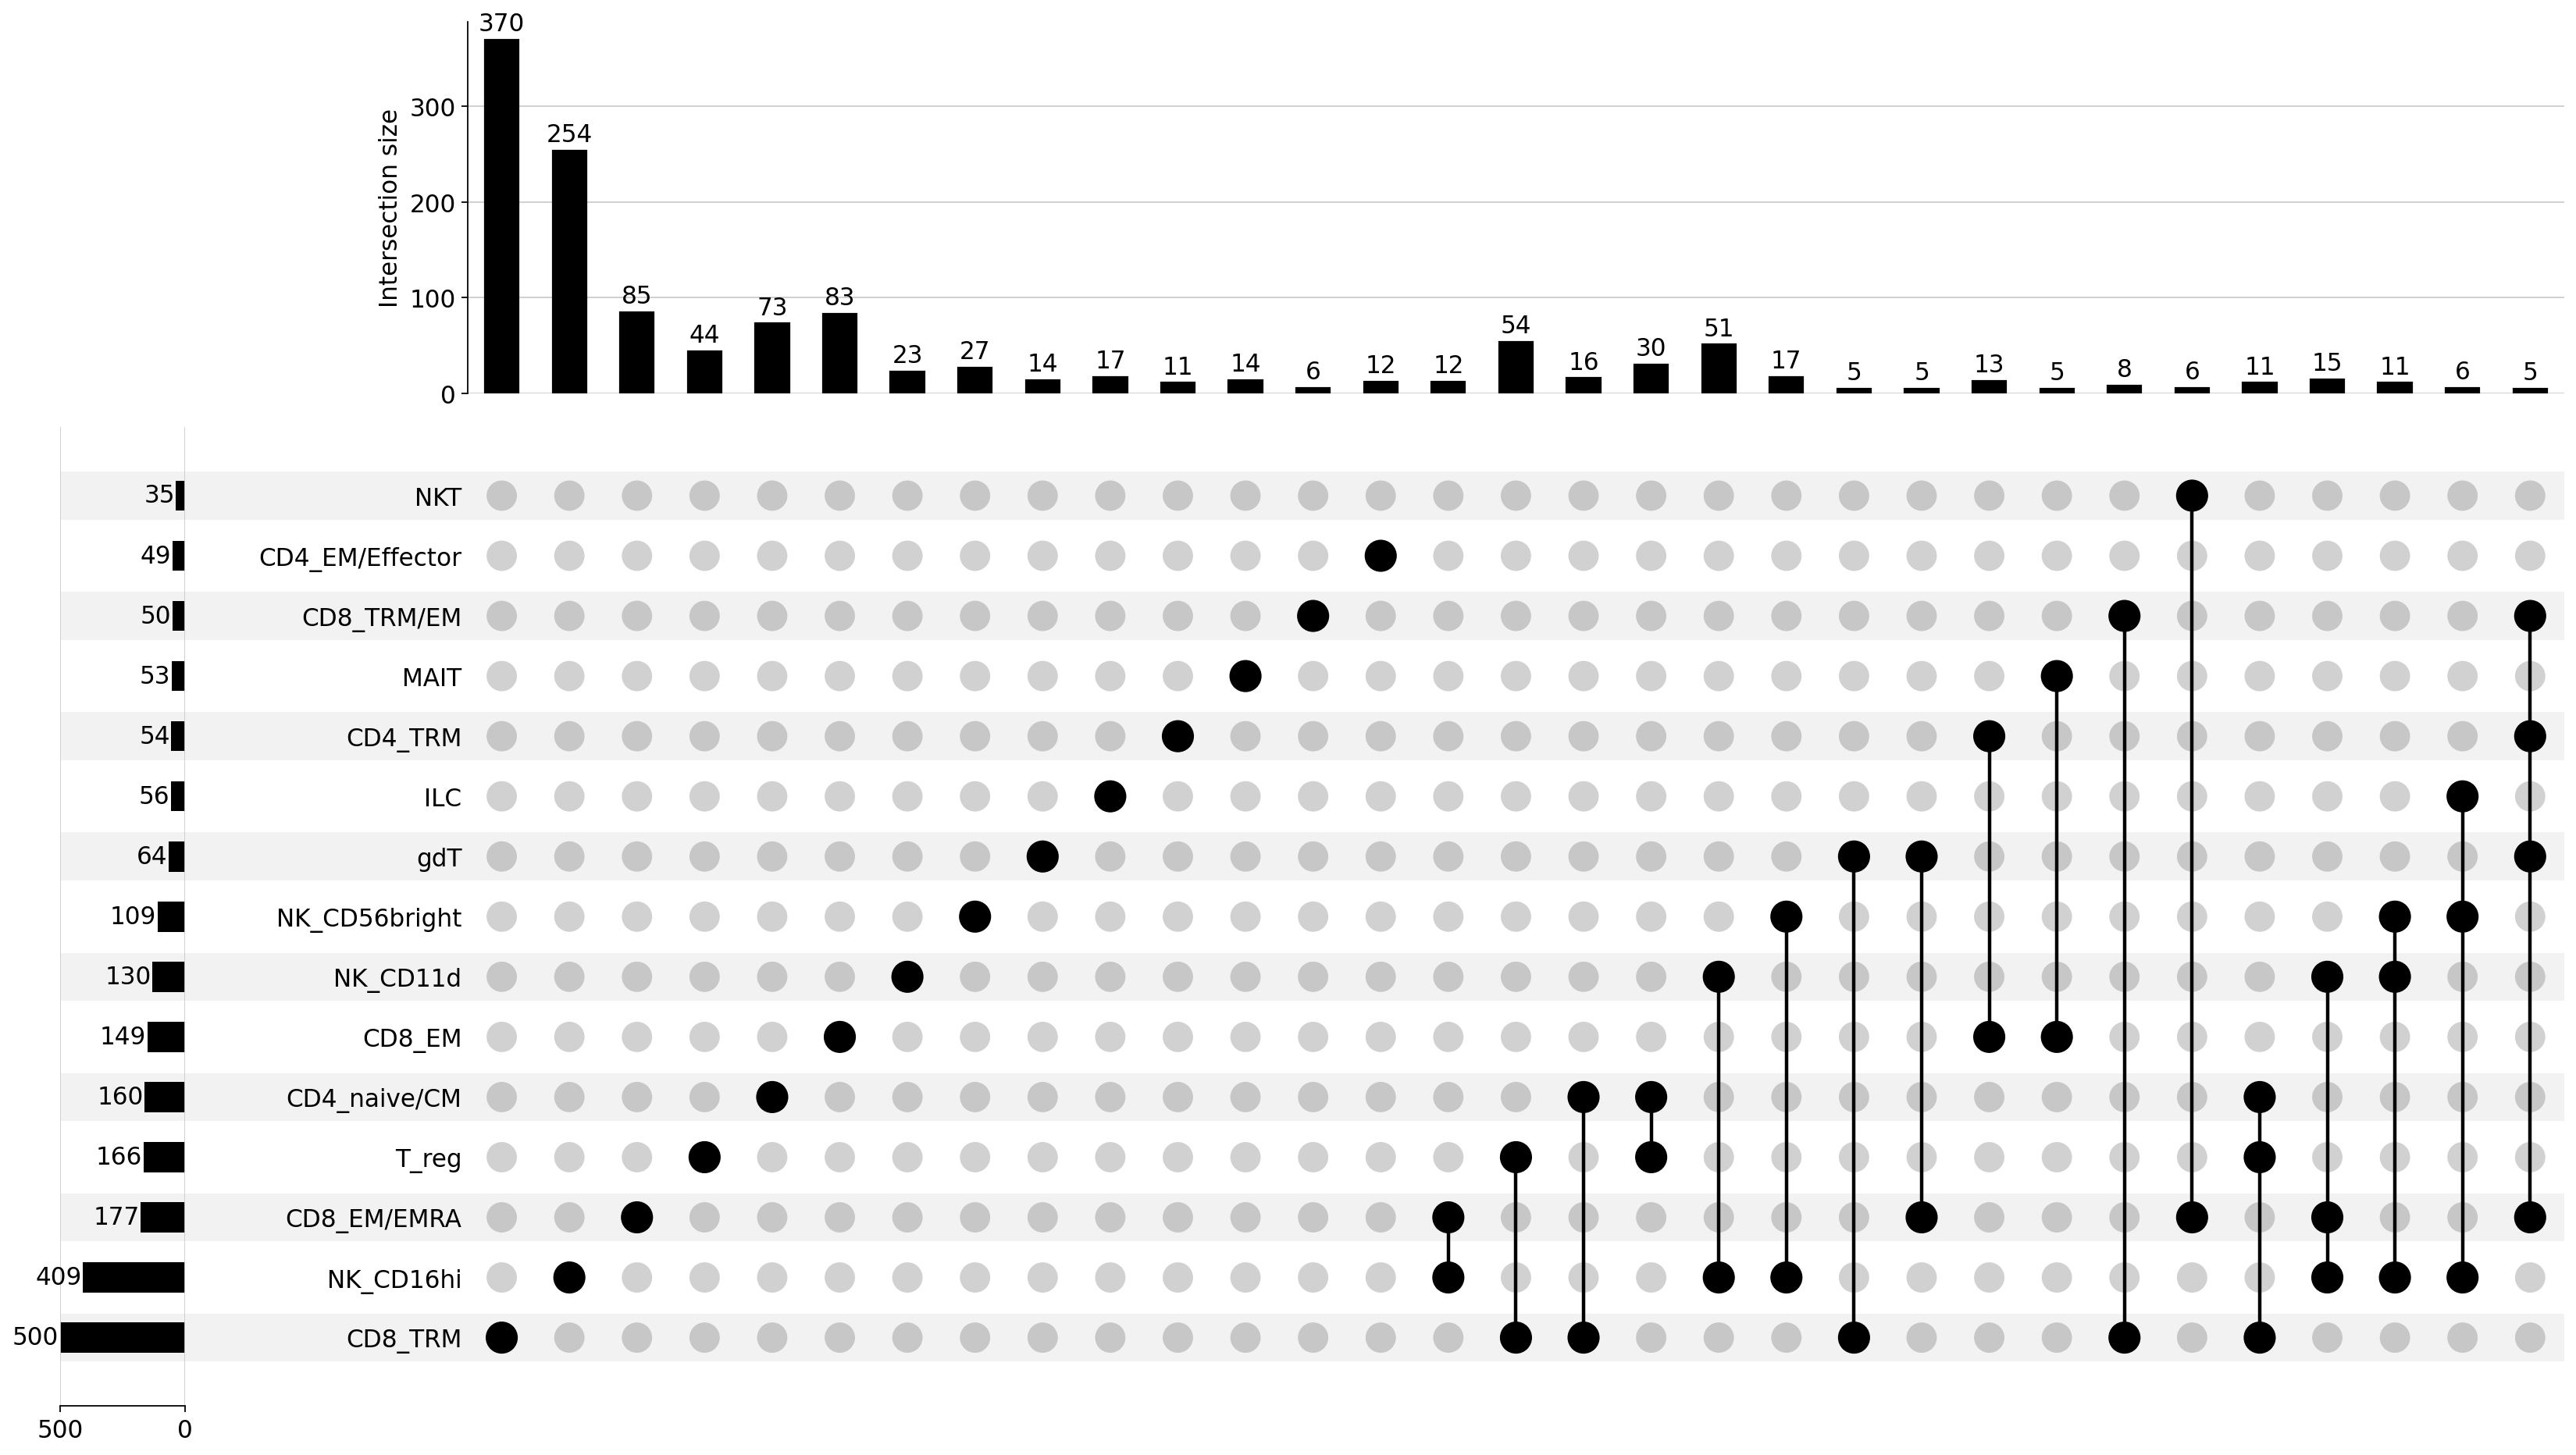

In [29]:
CT_500_markers = from_contents(Dict_markers)
plt = UpSet(CT_500_markers, min_subset_size=5, subset_size='count',sort_by="degree",
            element_size=50,  show_counts=True).plot()

In [30]:
Dict_markers['CD8_TRM'].loc[0:9]

0          ITGA1
1         THEMIS
2          STYK1
3        RASGRF2
4    KLRC4-KLRK1
5      EPHA1-AS1
6       ADAMTS17
7           CBLB
8          PARP8
9           HIP1
Name: names, dtype: object

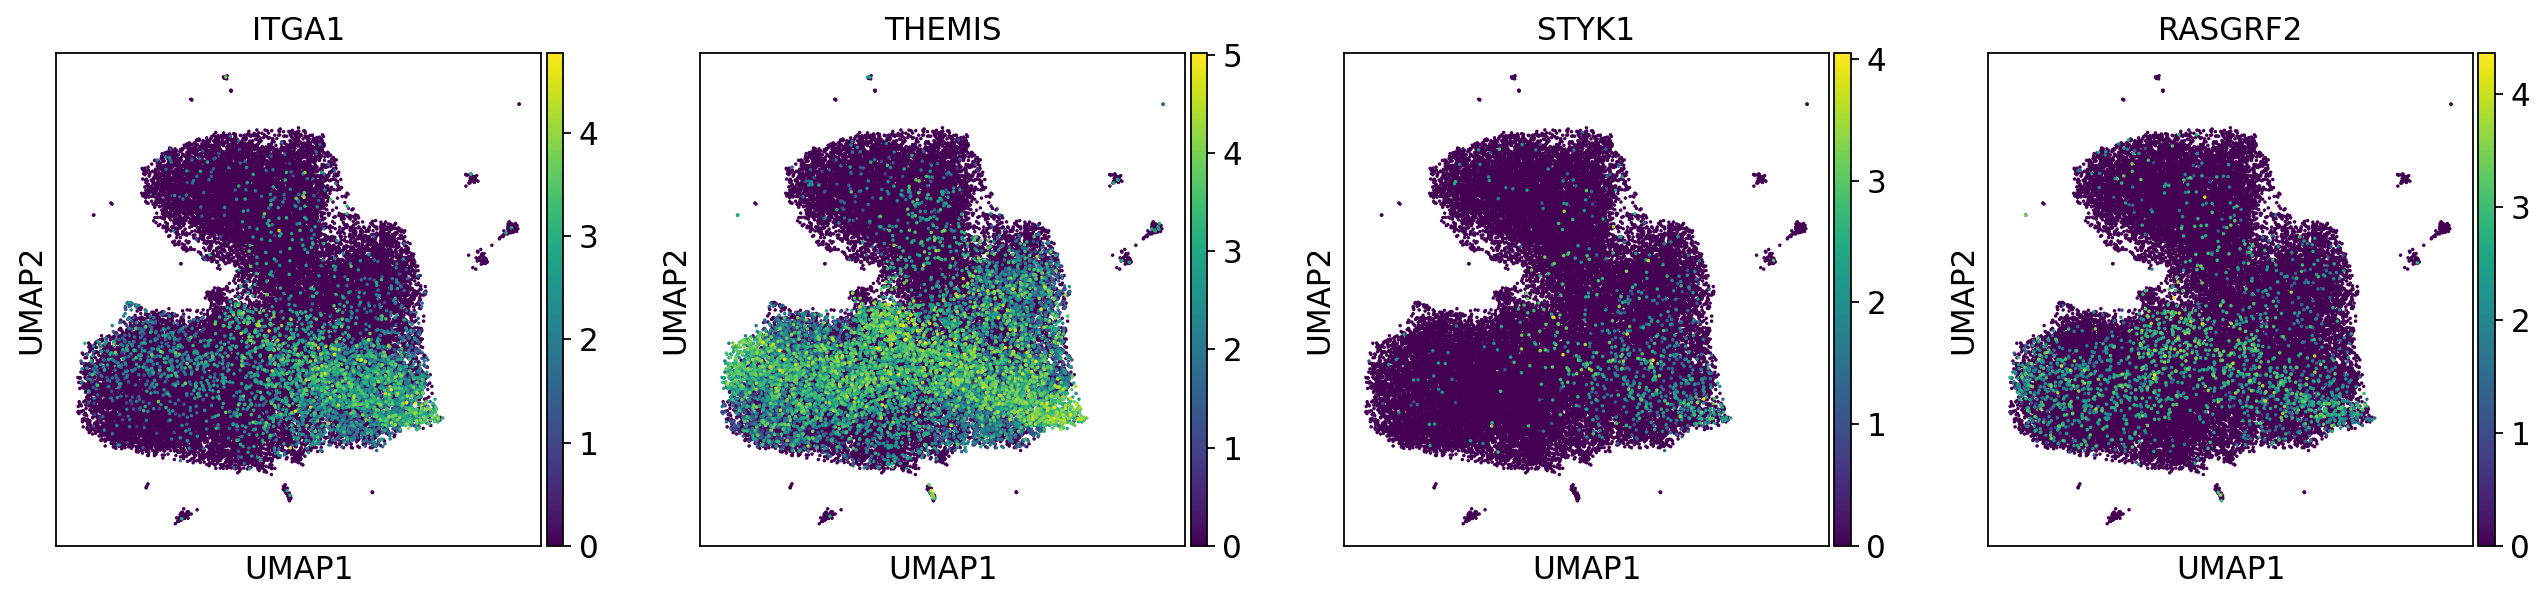

In [31]:
sc.pl.umap(adata, color=Dict_markers['CD8_TRM'].loc[0:3], size=10) # top

## Write markers to csv

In [32]:
full_csv_path = '/home/irepan/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Tcells/full.csv'

(pd.DataFrame.from_dict(data=CompleteDict_markers, orient='index')
   .to_csv(full_csv_path, header=False))

### Convert gene IDs to Ensemble IDs

In [33]:
%load_ext rpy2.ipython

In [34]:
%%R -i full_csv_path -w 5 -h 5 --units in -r 200
# import full_csv_path from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
library("EnsDb.Hsapiens.v86")

print(full_csv_path)

R[write to console]: Loading required package: ensembldb

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to cons

[1] "/home/irepan/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Tcells/full.csv"


In [35]:
%%R -i full_csv_path
library(stringr)

path <- "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Tcells/"

mycsv <- read.csv(full_csv_path, row.names = 1,header = F, na.strings = "")
genelists <- row.names(mycsv)

for (i in genelists)
    {
    f <- str_remove_all(i, "[()]")
    f <- str_replace_all(i, "/", "_")
    print(f)
    n <- sum(!is.na(mycsv[i,]))
    print(paste0(n," genes"))
    goi <- as.character(mycsv[i,1:n])
    print(goi[1:5])
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    print(head(ens_df))
    
    write(x = ens_df, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)
    }

[1] "CD8_EM_EMRA"
[1] "177 genes"
[1] "ZNF80" "GZMH"  "TTC16" "KLRG1" "TRGV2"
[1] "ENSG00000174255" "ENSG00000100450" "ENSG00000167094" "ENSG00000139187"
[5] "ENSG00000233306" "ENSG00000172116"
[1] "CD8_EM"
[1] "149 genes"
[1] "FXYD2"   "CD8B"    "TRBV9"   "TRBV3-1" "ITM2C"  
[1] "ENSG00000137731" "ENSG00000172116" "ENSG00000211716" "ENSG00000282204"
[5] "ENSG00000237702" "ENSG00000282624"
[1] "ILC"
[1] "56 genes"
[1] "TNFSF11" "KIT"     "AREG"    "FXYD7"   "SOX4"   
[1] "ENSG00000120659" "ENSG00000157404" "ENSG00000109321" "ENSG00000221946"
[5] "ENSG00000124766" "ENSG00000143184"
[1] "NK_CD11d"
[1] "130 genes"
[1] "ITGAD"   "KIR3DX1" "KLRC3"   "CHSY3"   "OPHN1"  
[1] "ENSG00000156886" "ENSG00000104970" "ENSG00000275918" "ENSG00000276033"
[5] "ENSG00000276848" "ENSG00000205810"
[1] "MAIT"
[1] "53 genes"
[1] "TRBV6-2" "SLC4A10" "TRAV1-2" "KLRB1"   "IL7R"   
[1] "ENSG00000282719" "ENSG00000283063" "ENSG00000144290" "ENSG00000256553"
[5] "ENSG00000111796" "ENSG00000168685"
[1] "T_reg"
[1]